<a href="https://colab.research.google.com/github/jacobpark1919/NBA_career_outcome_prediction/blob/main/NBA_career_outcome_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBA CAREER OUTCOME PREDICTOR

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn; seaborn.set()
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score # cross validation
# cross_val_score(model, X, y, cv=5)

from sklearn.model_selection import GridSearchCV # for tuning hyperparameters

# !pip install pydataset
# from pydataset import data

In [156]:
from google.colab import drive # link my google drive to this colab notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
# import data
player_data = pd.read_csv('/content/drive/MyDrive/Projects/Data/player_stats.csv') # put the spreadsheet into a data frame
awards = pd.read_csv('/content/drive/MyDrive/Projects/Data/awards_data.csv')
team_stats = pd.read_csv('/content/drive/MyDrive/Projects/Data/team_stats.csv')

This data does not come with a ppg metric or a rpg metric, so I must make these myself. Additionally, I must merge the two datasets so that each player has the awards as well as seasons stats in one dataframe

In [158]:
# make a copy of the data and make a ppg column
player_data_edit = player_data.copy()
player_data_edit['ppg'] = player_data_edit['points']/player_data_edit['games'] # make ppg column
player_data_edit['rpg'] = player_data_edit['tot_reb']/player_data_edit['games'] # make ppg column
player_data_edit['spg'] = player_data_edit['steals']/player_data_edit['games']
player_data_edit['apg'] = player_data_edit['ast']/player_data_edit['games']
player_data_edit['bpg'] = player_data_edit['blocks']/player_data_edit['games']
player_data_edit['off_rpg'] = player_data_edit['off_reb']/player_data_edit['games']
player_data_edit['def_rpg'] = player_data_edit['def_reb']/player_data_edit['games'] # make ppg column
player_data_edit.head(2)

# merge datasets
awards['all_star_game'] = awards['all_star_game'].fillna(0)  # Replace NaN with 0
player_data_awards = pd.merge(player_data_edit, awards, on=['season', 'nbapersonid'], how='left')
player_data_awards['all_star_game'] = player_data_awards['all_star_game'].fillna(0)

# First Attempt


This is the dataset that the model will predict. We will predict the career outcome of players based on their first four years.

In [159]:
# make a dataframe that has each player's first four seasons

player_data_awards['diff_first_curr'] = player_data_awards['season'] - player_data_awards['draftyear']
first_four = player_data_awards[player_data_awards['diff_first_curr'] <= 4]
# first_four

Career outcome will be based on the average of each player's best three seasons after their first four seasons.

In [160]:
# make a dataframe that has the average of each player's top 3 seasons

after_first_four = player_data_awards[player_data_awards['diff_first_curr'] >= 4]
after_first_four = after_first_four[after_first_four['games'] >= 30]
df_sorted = after_first_four.sort_values(by=['player', 'ppg'], ascending=[True, False])
player_data_top3 = df_sorted.groupby('player').head(3)
player_data_top3['all_star_game'] = player_data_top3['all_star_game'].replace({True:1, False:0})
numeric_cols = player_data_top3.select_dtypes(include=['number']).columns

# Calculate the mean only on these numeric columns
player_data_top3 = player_data_top3.groupby('player')[numeric_cols].mean()

<ipython-input-160-c9b4a1bc9299>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


These functions make it easy to calculate the top x% of each stat. This will make it easy to make the cutoffs for each bucket.

In [161]:
def stat_mean(df, stat_name, quantile):
    """
    This stat_mean() function takes a df, a stat name, and returns the top quantile of the mean of that stat

    df - dataframe that you want to operate on
    stat_name - the stat (ppg, win shares, rebounds, steals, etc) that you want to find top x% of
    quantile - the top percent that you want to find
    """
    df_describe = df[df['games'] >= 50]
    df_describe = df_describe.groupby('player')[stat_name].mean()
    quantile = df_describe.quantile(quantile)
    return quantile

def stat_sum(df, stat_name, quantile):
    """
    This stat_sum() function takes a df, a stat name, and returns the top quantile of the sum of that stat. This
    would be more useful that stat_mean() if you want the criteria to be per season and not per game (a player must play 5000
    minutes over the course of their career vs. a player must play 20 minutes a game etc.)

    df - dataframe that you want to operate on
    stat_name - the stat (ppg, win shares, rebounds, steals, etc) that you want to find top x% of
    quantile - the top percent that you want to find
    """
    df_describe = df[df['games'] >= 50]
    df_describe = df_describe.groupby('player')[stat_name].sum()
    quantile = df_describe.quantile(quantile)
    return quantile

In [162]:
# all nba bucket
"""
The all NBA bucket should have the criteria below OR have a previous all nba appearance
"""

# ppg
stat_name, quantile = 'ppg', 0.90
print("the top 10% score more than", stat_mean(player_data_top3, stat_name, quantile), " ppg")

# win shares
stat_name, quantile = 'WS', 0.90
print("the top 10% have more than ", stat_mean(player_data_top3, stat_name, quantile), " ws")

# offensive box plus minus
stat_name, quantile = 'OBPM', 0.80
print("the top 20% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

# PER
stat_name, quantile = 'PER', 0.80
print("the top 20% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

player_data_top3['All NBA'] = (((player_data_top3.loc[:,['All NBA First Team', 'All NBA Second Team', 'All NBA Third Team']] == 1).any(axis=1)) | ((player_data_top3['ppg'] >=21.359) & (player_data_top3['WS'] >= 8.033) & (player_data_top3['OBPM'] >= 2.0735) & (player_data_top3['PER'] >= 19.052)))

p = player_data_top3[player_data_top3['All NBA'] == True]
p = p.groupby(['player', 'All NBA'])
len(p)


the top 10% score more than 20.404372676302764  ppg
the top 10% have more than  7.740000000000002  ws
the top 20% have more than  1.75  OBPM
the top 20% have more than  18.466666666666665  OBPM


35

In [163]:
# all star bucket
"""
The all NBA bucket should have the criteria below OR have a previous all nba appearance
"""

# ppg
stat_name, quantile = 'ppg', 0.75
print("the top 10% score more than", stat_mean(player_data_top3, stat_name, quantile), " ppg")

# win shares
stat_name, quantile = 'WS', 0.75
print("the top 10% have more than ", stat_mean(player_data_top3, stat_name, quantile), " ws")

# offensive box plus minus
stat_name, quantile = 'OBPM', 0.65
print("the top 20% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

# PER
stat_name, quantile = 'PER', 0.65
print("the top 20% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

player_data_top3['All Star'] = (((player_data_top3['all_star_game'] >= 0.3) | ((player_data_top3['ppg'] >=16.66) & (player_data_top3['WS'] >= 5.5) & (player_data_top3['OBPM'] >= 1.0) & (player_data_top3['PER'] >= 16.8))) & (player_data_top3['All NBA'] == False))

d = player_data_top3[player_data_top3['All Star'] == True]
p = d.groupby(['player', 'All Star'])
len(p)

the top 10% score more than 15.706602438007506  ppg
the top 10% have more than  5.425000000000001  ws
the top 20% have more than  0.7616666666666674  OBPM
the top 20% have more than  16.2  OBPM


76

In [164]:
# starter bucket

# ppg
stat_name, quantile = 'ppg', 0.5
print("the top 50% score more than", stat_mean(player_data_top3, stat_name, quantile), " ppg")

# win shares
stat_name, quantile = 'WS', 0.5
print("the top 50% have more than ", stat_mean(player_data_top3, stat_name, quantile), " ws")

# offensive box plus minus
stat_name, quantile = 'OBPM', 0.4
print("the top 60% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

# PER
stat_name, quantile = 'PER', 0.4
print("the top 60% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

player_data_top3['Starter'] = (((player_data_top3['ppg'] >= 11.4) & (player_data_top3['WS'] >= 3.9) & (player_data_top3['OBPM'] >= -0.4) & (player_data_top3['PER'] >= 14.0)) & ((player_data_top3['All NBA'] == False) & (player_data_top3['All Star'] == False)))

d = player_data_top3[player_data_top3['Starter'] == True]
p = d.groupby(['player', 'Starter'])
len(p)

the top 50% score more than 10.513931160664217  ppg
the top 50% have more than  3.6  ws
the top 60% have more than  -0.6  OBPM
the top 60% have more than  13.543333333333335  OBPM


78

In [165]:
# bench bucket

# ppg
stat_name, quantile = 'ppg', 0.25
print("the top 75% score more than", stat_mean(player_data_top3, stat_name, quantile), " ppg")

# win shares
stat_name, quantile = 'WS', 0.25
print("the top 75% have more than ", stat_mean(player_data_top3, stat_name, quantile), " ws")

# offensive box plus minus
stat_name, quantile = 'OBPM', 0.2
print("the top 80% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

# PER
stat_name, quantile = 'PER', 0.2
print("the top 80% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

player_data_top3['Bench'] = ((((player_data_top3['ppg'] >= 7.7) & (player_data_top3['WS'] >= 2.4) & (player_data_top3['OBPM'] >= 2.39) & (player_data_top3['PER'] >= -1.5)) & ((player_data_top3['All NBA'] == False) & (player_data_top3['All Star'] == False) & (player_data_top3['Starter'] == False))) | ((player_data_top3['mins'] >= 1000) & ((player_data_top3['All NBA'] == False) & (player_data_top3['All Star'] == False) & (player_data_top3['Starter'] == False))))

d = player_data_top3[player_data_top3['Bench'] == True]
p = d.groupby(['player', 'Bench'])
len(p)
# d

the top 75% score more than 7.167982619600138  ppg
the top 75% have more than  2.1  ws
the top 80% have more than  -1.7099999999999995  OBPM
the top 80% have more than  11.466666666666667  OBPM


353

In [166]:
# Out of the league bucket

player_data_top3['Out of the league'] = (((player_data_top3['All NBA'] == False) & (player_data_top3['All Star'] == False) & (player_data_top3['Starter'] == False) & (player_data_top3['Bench'] == False)))

d = player_data_top3[player_data_top3['Out of the league'] == True]
p = d.groupby(['player', 'Out of the league'])
len(p)
# d


203

In [167]:
player_data_top3['Career Outcome'] = player_data_top3.loc[:,'All NBA':].idxmax(axis=1)
player_data_top3.head(3)


,nbapersonid,draftyear,draftpick,season,nbateamid,games,games_start,mins,fgm,fga,fgp,fgm3,fga3,fgp3,fgm2,fga2,fgp2,efg,ftm,fta,ftp,off_reb,def_reb,tot_reb,ast,steals,blocks,tov,tot_fouls,points,PER,FTr,off_reb_pct,def_reb_pct,tot_reb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg,OWS,DWS,WS,OBPM,DBPM,BPM,VORP,ppg,rpg,spg,apg,bpg,off_rpg,def_rpg,All NBA Defensive First Team,All NBA Defensive Second Team,All NBA First Team,All NBA Second Team,All NBA Third Team,All Rookie First Team,All Rookie Second Team,Bill Russell NBA Finals MVP,Player Of The Month,Player Of The Week,Rookie Of The Month,all_star_game,allstar_rk,Defensive Player Of The Year_rk,Most Improved Player_rk,Most Valuable Player_rk,Rookie Of The Year_rk,Sixth Man Of The Year_rk,all_nba_points_rk,all_rookie_points_rk,diff_first_curr,All NBA,All Star,Starter,Bench,Out of the league,Career Outcome
player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron Brooks,201166.0,2007.0,26.0,2013.666667,1.610613e+09,65.666667,13.666667,1317.333333,223.666667,529.666667,0.427000,78.333333,208.333333,0.374000,145.333333,321.333333,0.463000,0.501333,78.000000,96.666667,0.789333,21.666667,93.333333,115.000000,183.000000,37.666667,10.666667,100.666667,136.666667,603.666667,12.766667,0.173667,0.017667,0.077000,0.047667,0.226667,0.014667,0.006333,0.151000,0.219667,0.933333,0.733333,1.700000,-0.566667,-1.266667,-1.833333,0.100000,8.902203,1.727937,0.574585,2.713150,0.160009,0.318487,1.409450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,6.666667,False,False,False,True,False,Bench
Aaron Gordon,203932.0,2014.0,4.0,2019.333333,1.610613e+09,71.666667,71.666667,2342.000000,413.000000,882.333333,0.468667,93.666667,281.333333,0.330667,319.333333,601.000000,0.532667,0.521333,169.000000,235.666667,0.716000,120.333333,375.666667,496.000000,235.000000,50.666667,46.333333,131.666667,148.333333,1088.666667,15.166667,0.270000,0.056000,0.176667,0.115667,0.152000,0.010667,0.017333,0.117333,0.207333,2.133333,2.533333,4.666667,0.233333,-0.233333,0.000000,1.200000,15.135682,6.957866,0.713339,3.296405,0.644549,1.682106,5.275760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.333333,False,False,True,False,False,Starter
Aaron Gray,201189.0,2007.0,49.0,2012.000000,1.610613e+09,41.333333,20.666667,553.666667,52.000000,103.000000,0.493333,0.000000,0.333333,0.000000,52.000000,102.666667,0.496000,0.493333,19.333333,36.333333,0.537000,56.666667,115.666667,172.333333,26.333333,13.000000,10.000000,38.000000,89.666667,123.333333,9.333333,0.363667,0.120000,0.233667,0.177000,0.078667,0.012333,0.014667,0.252667,0.129333,0.033333,0.700000,0.666667,-4.033333,-0.066667,-4.100000,-0.266667,2.849825,4.007524,0.306226,0.637497,0.236137,1.339518,2.668007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,False,False,False,False,True,Out of the league


In [168]:
# plt.hist(x = player_data_top3['Career Outcome'])

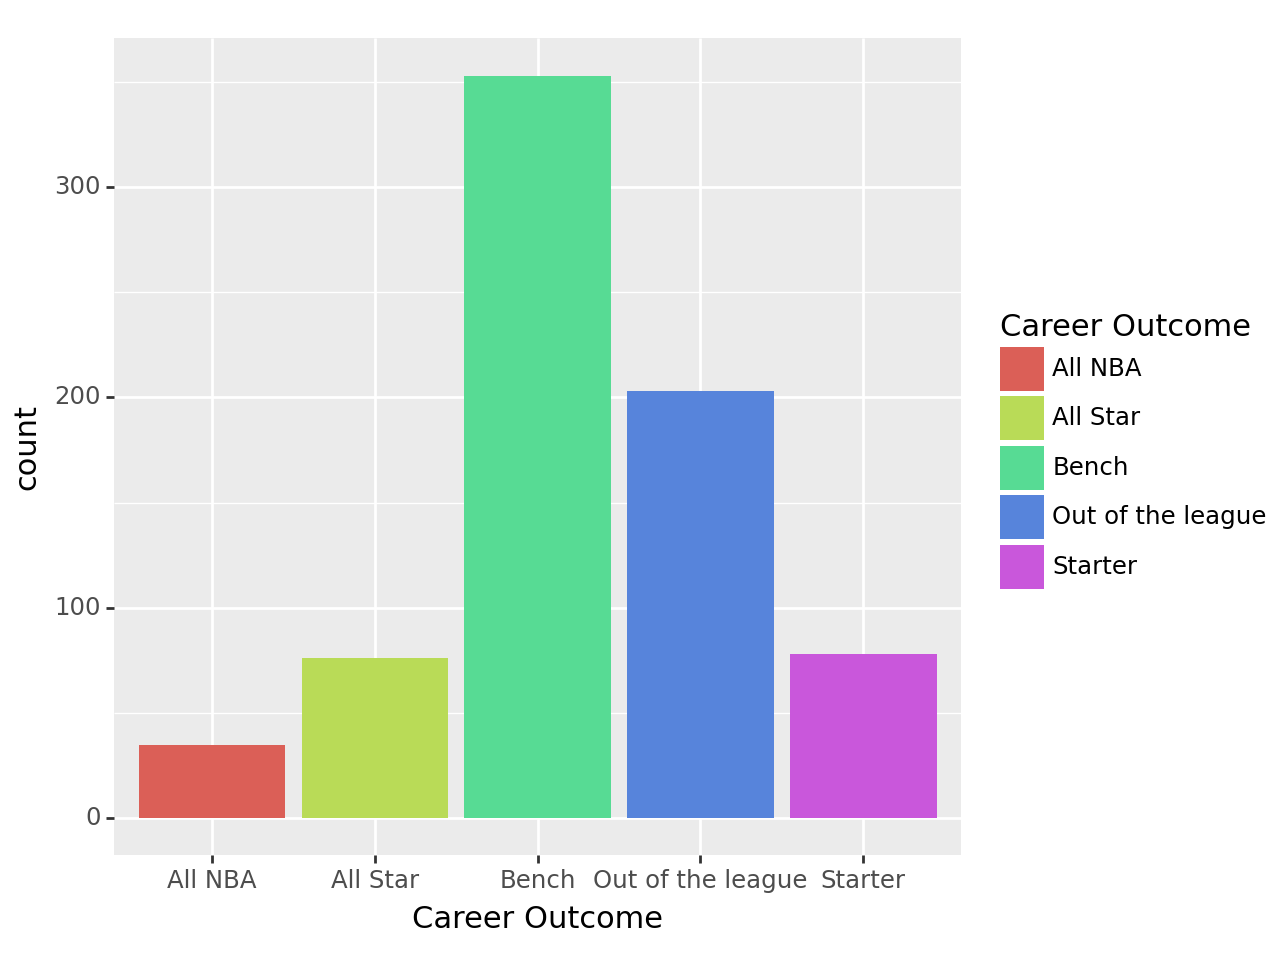

<Figure Size: (640 x 480)>

In [169]:
ggplot(player_data_top3, aes(x = 'Career Outcome', fill = 'Career Outcome')) + geom_bar()

One potential hurdle is that there is not a lot of data in the all nba bucket. This could make our training data a bit unreliable.

In [170]:
X = player_data_top3.loc[:,['ppg', 'WS', 'OBPM', 'PER', 'efg']] # features matrix
y = player_data_top3['Career Outcome']

model = GaussianNB()

X1, X2, y1, y2 =  train_test_split(X, y, random_state = 0, train_size = 0.8)

model.fit(X1,y1)

GaussianNB()

In [171]:
y2_predict = model.predict(X2)
acc = pd.DataFrame({'y2_predict':y2_predict, 'y2_real':y2})
acc.head(5)

,y2_predict,y2_real
player,,
Tim Frazier,Out of the league,Out of the league
Metta World Peace,Starter,Starter
Alexis Ajinca,Bench,Out of the league
Andrew Bynum,Starter,All NBA
Daniel Theis,Bench,Bench


In [172]:
print(classification_report(y2_predict, y2))
print(accuracy_score(y2_predict,y2))

                   precision    recall  f1-score   support

          All NBA       0.43      0.75      0.55         4
         All Star       0.67      0.75      0.71        16
            Bench       0.69      0.83      0.75        64
Out of the league       0.78      0.60      0.67        47
          Starter       0.55      0.33      0.41        18

         accuracy                           0.68       149
        macro avg       0.62      0.65      0.62       149
     weighted avg       0.69      0.68      0.68       149

0.6845637583892618


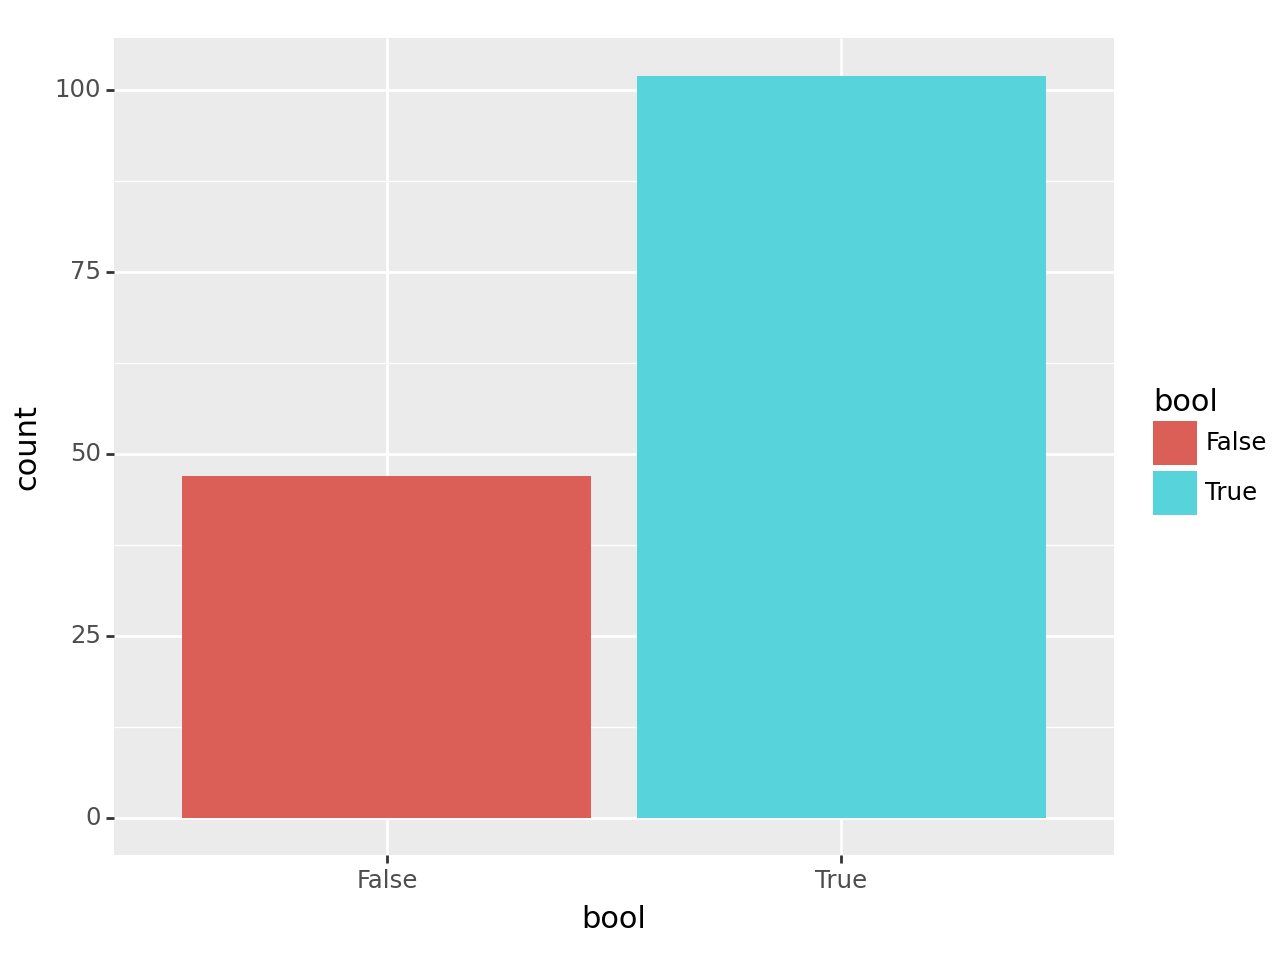

<Figure Size: (640 x 480)>

In [173]:
test1 = acc.iloc[:,0] == acc.iloc[:,1]
test1_df = pd.DataFrame(test1)
test1_df.rename(columns = {0: 'bool'}, inplace = True)
ggplot(test1_df, aes(x = 'bool', fill = 'bool')) + geom_bar()

In [174]:
# cross validation

scores = cross_val_score(model, X, y, cv=5)
scores

array([0.79194631, 0.71812081, 0.71812081, 0.77181208, 0.77852349])

In [175]:
X_young = first_four.loc[:,['player', 'ppg', 'WS', 'OBPM', 'PER', 'efg']]
X_young.set_index('player', inplace=True)
X_young = X_young.dropna()
young_players = model.predict(X_young)
young_players

array(['Out of the league', 'Out of the league', 'Starter', ..., 'Bench',
       'Bench', 'Bench'], dtype='<U17')

In [176]:
final = pd.DataFrame({'Player':X_young.index, 'Career Outcome Prediction': young_players})
final.set_index('Player', inplace = True)

In [177]:
# final = final.set_index('Player')
final

,Career Outcome Prediction
Player,
Zaza Pachulia,Out of the league
Solomon Jones,Out of the league
Josh Smith,Starter
Acie Law,Out of the league
Salim Stoudamire,Out of the league
...,...
Alize Johnson,Out of the league
Jordan Schakel,Out of the league
Corey Kispert,Bench


In [178]:
prob = model.predict_proba(X_young)
final3 = pd.DataFrame(data = prob.round(2), index = X_young.index)

In [179]:
final3

,0,1,2,3,4
player,,,,,
Zaza Pachulia,0.0,0.00,0.00,1.00,0.00
Solomon Jones,0.0,0.00,0.00,1.00,0.00
Josh Smith,0.0,0.19,0.01,0.00,0.80
Acie Law,0.0,0.00,0.00,1.00,0.00
Salim Stoudamire,0.0,0.00,0.03,0.97,0.00
...,...,...,...,...,...
Alize Johnson,0.0,0.00,0.00,1.00,0.00
Jordan Schakel,0.0,0.00,0.00,1.00,0.00
Corey Kispert,0.0,0.00,0.96,0.04,0.00


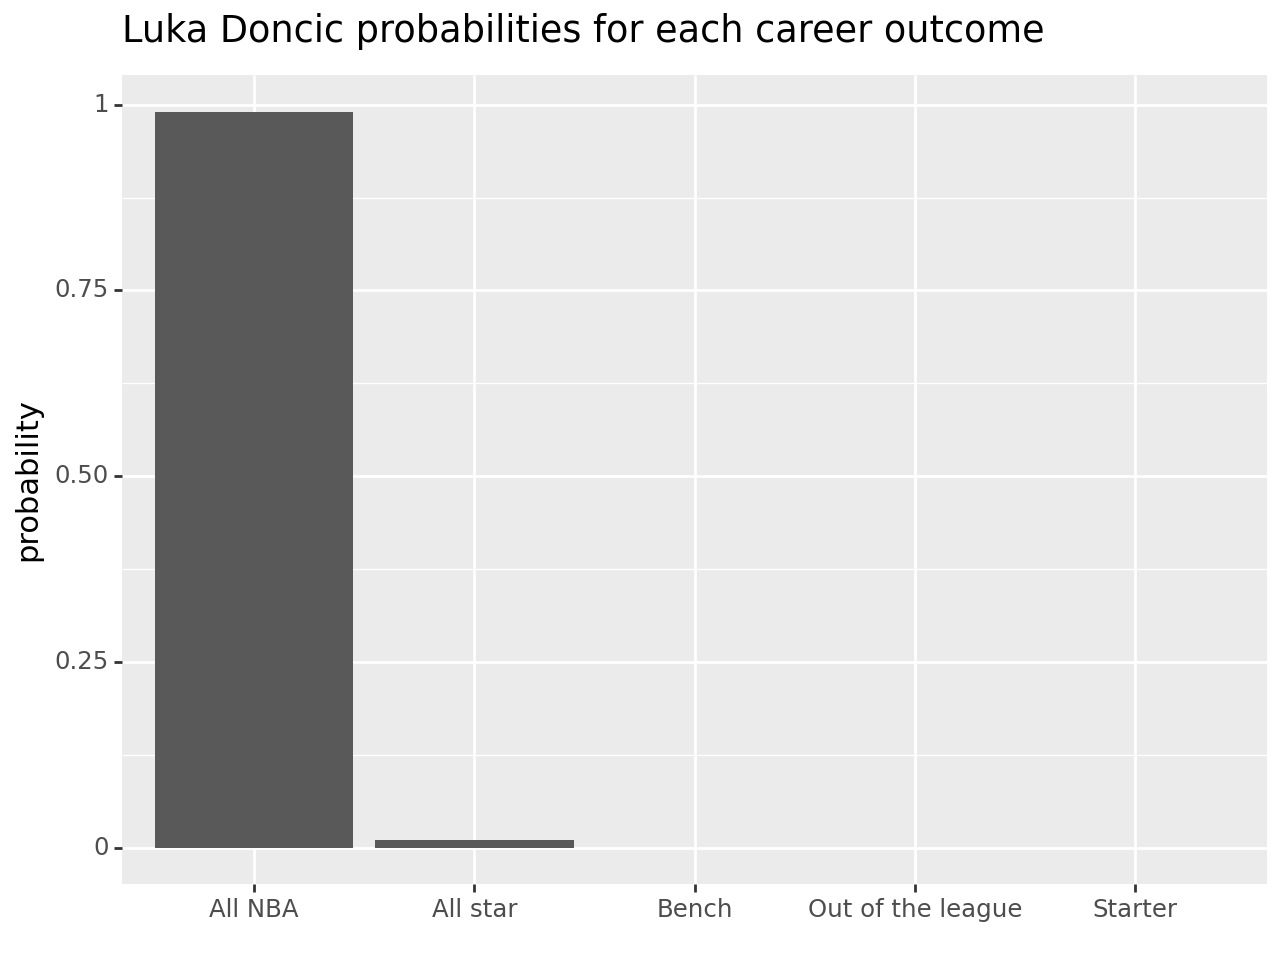

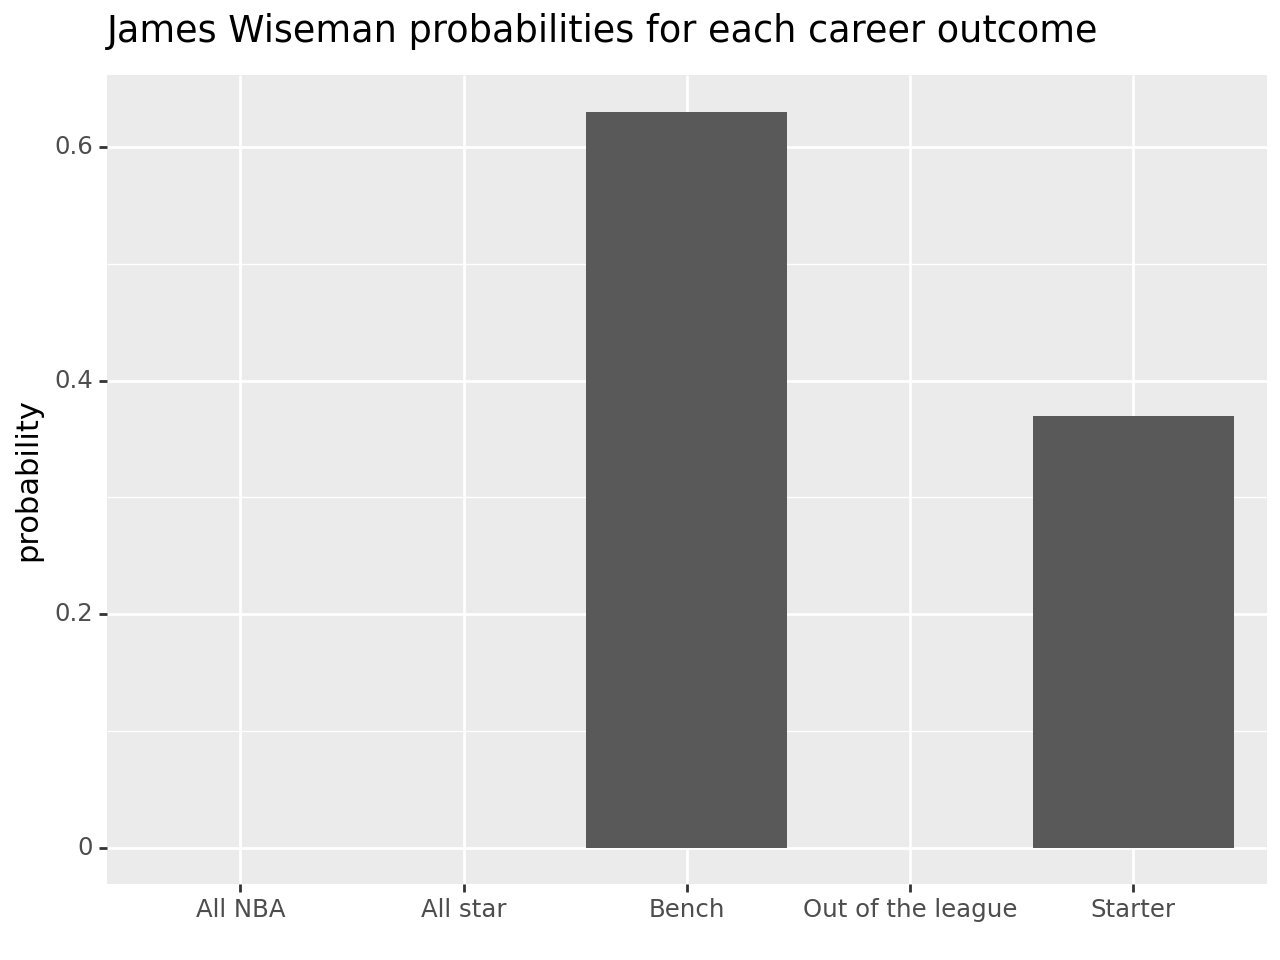

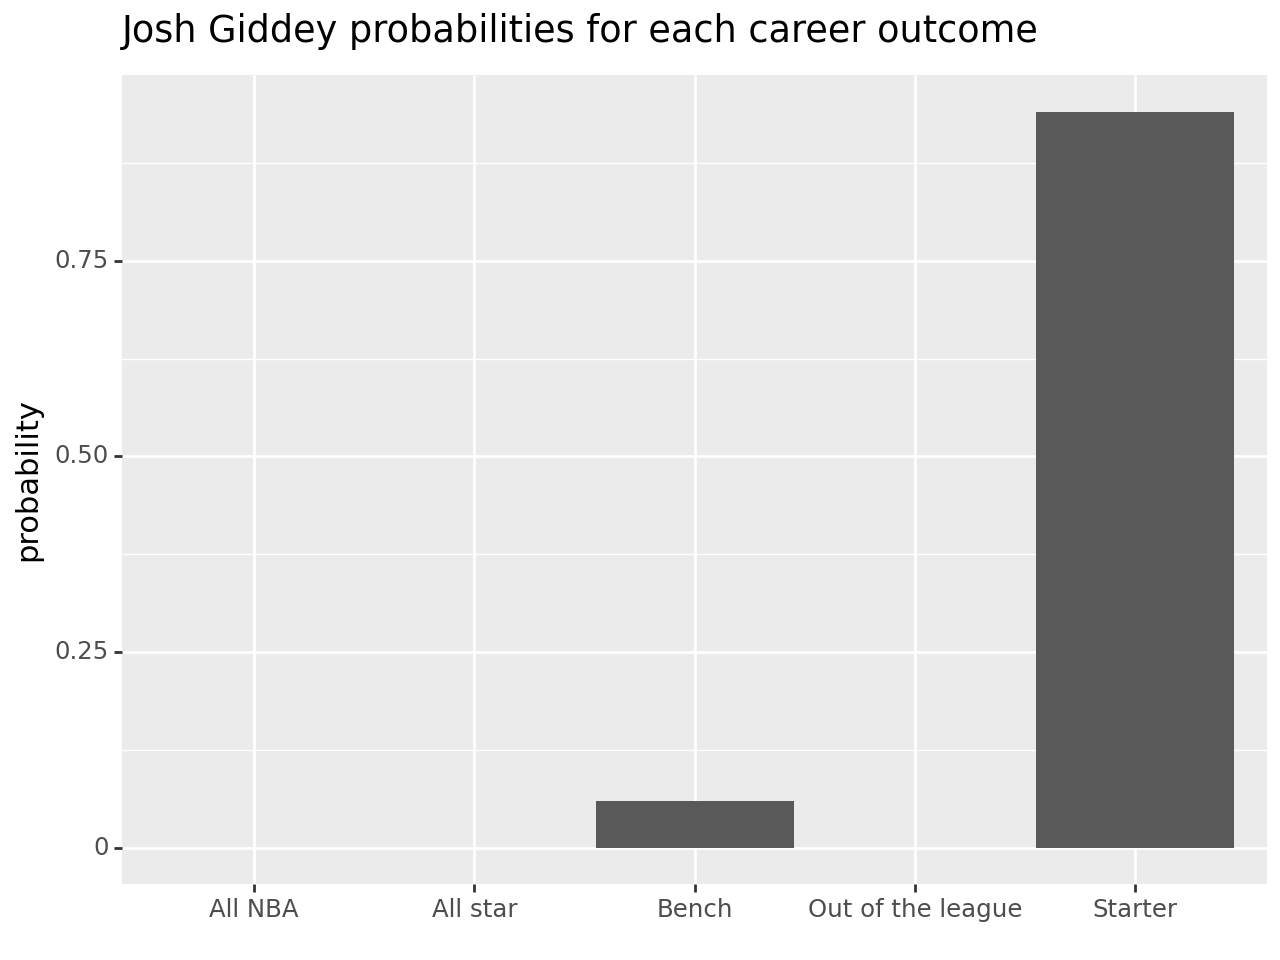

In [180]:
def player_bar_chart(df, players):
  """
  This function creates a bar chart of the probabilities of each career outcome
  of each player in the players argument
  """
  for i in range(len(players)):
    name = df.loc[players[i]]
    name = pd.DataFrame(name)
    name.rename(columns = {0: players[i]}, index = {0:'All NBA', 1:"All star", 2:"Starter", 3: "Bench", 4:"Out of the league"}, inplace = True)
    print(ggplot(name, aes(x = name.index, y = players[i])) + geom_col() + labs(y = 'probability', title = players[i] + " probabilities for each career outcome"))

df = final3
players = ['Luka Doncic', 'James Wiseman', 'Josh Giddey'] # change to see different players

player_bar_chart(df, players)

# Second Attempt

Right now, this model just classifies players into different career outcome buckets. The goal is to truly predict what these players will become.

Here's how to do this

Predict the stats of each young player using regression. Based on those predicted stats, you calssify them into a category.

So this would mean making a dataframe with all older players, and taking only their stats from their first four seasons. You make one row for each player my averageing all of their first four seasons. Then you make extra columsn with their stats from their best seasons. The stats from the first four seasons become the features matrix, and the stats from the best seaon become the target vector. you need to make multiple regression models for all of the stats in the target vector.

Once oyu predict every player's stats, then you classify them with a classification model.

### cleaning

In [181]:
player_data2 = player_data_awards.copy()
player_data2

,nbapersonid,player,draftyear,draftpick,season,nbateamid,team,games,games_start,mins,fgm,fga,fgp,fgm3,fga3,fgp3,fgm2,fga2,fgp2,efg,ftm,fta,ftp,off_reb,def_reb,tot_reb,ast,steals,blocks,tov,tot_fouls,points,PER,FTr,off_reb_pct,def_reb_pct,tot_reb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg,OWS,DWS,WS,OBPM,DBPM,BPM,VORP,ppg,rpg,spg,apg,bpg,off_rpg,def_rpg,All NBA Defensive First Team,All NBA Defensive Second Team,All NBA First Team,All NBA Second Team,All NBA Third Team,All Rookie First Team,All Rookie Second Team,Bill Russell NBA Finals MVP,Player Of The Month,Player Of The Week,Rookie Of The Month,all_star_game,rookie_all_star_game,allstar_rk,Defensive Player Of The Year_rk,Most Improved Player_rk,Most Valuable Player_rk,Rookie Of The Year_rk,Sixth Man Of The Year_rk,all_nba_points_rk,all_rookie_points_rk,diff_first_curr
0,2585,Zaza Pachulia,2003,42.0,2007,1610612737,ATL,62,5,944,107,245,0.437,0,3,0.000,107,242,0.442,0.437,108,153,0.706,89,159,248,36,24,13,69,140,322,11.0,0.624,0.110,0.195,0.153,0.060,0.013,0.010,0.181,0.183,0.2,0.9,1.1,-3.9,-1.3,-5.1,-0.7,5.193548,4.000000,0.387097,0.580645,0.209677,1.435484,2.564516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,200780,Solomon Jones,2006,33.0,2007,1610612737,ATL,35,0,145,12,30,0.400,0,2,0.000,12,28,0.429,0.400,11,20,0.550,19,23,42,0,3,5,11,28,35,6.8,0.667,0.153,0.184,0.169,0.000,0.011,0.026,0.221,0.156,-0.1,0.1,0.0,-6.7,-2.0,-8.8,-0.2,1.000000,1.200000,0.085714,0.000000,0.142857,0.542857,0.657143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2746,Josh Smith,2004,17.0,2007,1610612737,ATL,81,81,2873,518,1133,0.457,25,99,0.253,493,1034,0.477,0.468,333,469,0.710,161,506,667,272,123,227,245,269,1394,19.0,0.414,0.066,0.204,0.135,0.166,0.023,0.059,0.155,0.250,1.2,4.6,5.8,0.5,2.5,3.0,3.7,17.209877,8.234568,1.518519,3.358025,2.802469,1.987654,6.246914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3
3,201151,Acie Law,2007,11.0,2007,1610612737,ATL,56,6,865,95,237,0.401,7,34,0.206,88,203,0.433,0.416,38,48,0.792,12,45,57,113,29,0,56,73,235,7.7,0.203,0.016,0.060,0.038,0.204,0.018,0.000,0.178,0.165,-0.5,0.4,-0.1,-4.2,-1.0,-5.2,-0.7,4.196429,1.017857,0.517857,2.017857,0.000000,0.214286,0.803571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,101136,Salim Stoudamire,2005,31.0,2007,1610612737,ATL,35,0,402,65,180,0.361,29,85,0.341,36,95,0.379,0.442,41,50,0.820,4,20,24,28,7,5,21,34,200,11.1,0.278,0.012,0.058,0.035,0.119,0.009,0.009,0.094,0.252,0.1,0.1,0.3,-1.0,-2.5,-3.5,-0.1,5.714286,0.685714,0.200000,0.800000,0.142857,0.114286,0.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,1630648,Jordan Schakel,2021,NaN,2021,1610612764,WAS,4,0,30,1,11,0.091,1,6,0.167,0,5,0.000,0.136,2,2,1.000,2,6,8,0,1,0,1,0,5,-1.2,0.182,0.075,0.218,0.148,0.000,0.016,0.000,0.078,0.191,-0.2,0.0,-0.1,-8.6,-4.4,-13.0,-0.1,1.250000,2.000000,0.250000,0.000000,0.000000,0.500000,1.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8494,1630557,Corey Kispert,2021,15.0,2021,1610612764,WAS,77,36,1801,234,514,0.455,112,320,0.350,122,194,0.629,0.564,54,62,0.871,53,156,209,85,35,22,50,93,634,10.9,0.121,0.033,0.094,0.064,0.067,0.010,0.010,0.085,0.146,1.6,0.7,2.3,-0.8,-1.5,-2.3,-0.1,8.233766,2.714286,0.454545,1.103896,0.285714,0.688312,2.025974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8495,1628398,Kyle Kuzma,2017,27.0,2021,1610612764,WAS,66,66,2204,423,936,0.452,128,375,0.341,295,561,0.526,0.520,156,219,0.712,70,491,561,233,42,57,169,128,1130,15.2,0

In [182]:
# df player_data2_young is all the players who have played at least 6 years already and
# only contains data from these players' first four years
player_data2_young = player_data2

max_season = player_data2_young.groupby('player')['season'].transform(max)
player_data2_young['career length'] = max_season - player_data2_young['draftyear']
player_data2_young['difference'] = player_data2['season'] - player_data2['draftyear']

# keep only players that have played at least 7 years
player_data2_young = player_data2_young[player_data2_young['career length'] >= 7]

# keep only the first 4 seasons of these players who have played at least 10 years
player_data2_young = player_data2_young[player_data2_young['difference'] <= 4]
#player_data2_young.drop('career_length', axis = 1, inplace = True)
player_data2_young

,nbapersonid,player,draftyear,draftpick,season,nbateamid,team,games,games_start,mins,fgm,fga,fgp,fgm3,fga3,fgp3,fgm2,fga2,fgp2,efg,ftm,fta,ftp,off_reb,def_reb,tot_reb,ast,steals,blocks,tov,tot_fouls,points,PER,FTr,off_reb_pct,def_reb_pct,tot_reb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg,OWS,DWS,WS,OBPM,DBPM,BPM,VORP,ppg,rpg,spg,apg,bpg,off_rpg,def_rpg,All NBA Defensive First Team,All NBA Defensive Second Team,All NBA First Team,All NBA Second Team,All NBA Third Team,All Rookie First Team,All Rookie Second Team,Bill Russell NBA Finals MVP,Player Of The Month,Player Of The Week,Rookie Of The Month,all_star_game,rookie_all_star_game,allstar_rk,Defensive Player Of The Year_rk,Most Improved Player_rk,Most Valuable Player_rk,Rookie Of The Year_rk,Sixth Man Of The Year_rk,all_nba_points_rk,all_rookie_points_rk,diff_first_curr,career length,difference
0,2585,Zaza Pachulia,2003,42.0,2007,1610612737,ATL,62,5,944,107,245,0.437,0,3,0.000,107,242,0.442,0.437,108,153,0.706,89,159,248,36,24,13,69,140,322,11.0,0.624,0.110,0.195,0.153,0.060,0.013,0.010,0.181,0.183,0.2,0.9,1.1,-3.9,-1.3,-5.1,-0.7,5.193548,4.000000,0.387097,0.580645,0.209677,1.435484,2.564516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,15,4
1,200780,Solomon Jones,2006,33.0,2007,1610612737,ATL,35,0,145,12,30,0.400,0,2,0.000,12,28,0.429,0.400,11,20,0.550,19,23,42,0,3,5,11,28,35,6.8,0.667,0.153,0.184,0.169,0.000,0.011,0.026,0.221,0.156,-0.1,0.1,0.0,-6.7,-2.0,-8.8,-0.2,1.000000,1.200000,0.085714,0.000000,0.142857,0.542857,0.657143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7,1
2,2746,Josh Smith,2004,17.0,2007,1610612737,ATL,81,81,2873,518,1133,0.457,25,99,0.253,493,1034,0.477,0.468,333,469,0.710,161,506,667,272,123,227,245,269,1394,19.0,0.414,0.066,0.204,0.135,0.166,0.023,0.059,0.155,0.250,1.2,4.6,5.8,0.5,2.5,3.0,3.7,17.209877,8.234568,1.518519,3.358025,2.802469,1.987654,6.246914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3,13,3
5,2735,Josh Childress,2004,6.0,2007,1610612737,ATL,76,0,2274,327,573,0.571,22,60,0.367,305,513,0.595,0.590,222,275,0.807,174,199,373,117,71,43,98,129,898,17.8,0.480,0.090,0.102,0.096,0.085,0.016,0.014,0.124,0.158,6.0,1.5,7.6,2.3,-0.3,2.0,2.3,11.815789,4.907895,0.934211,1.539474,0.565789,2.289474,2.618421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,3,9,3
10,201143,Al Horford,2007,3.0,2007,1610612737,ATL,81,77,2540,333,668,0.499,0,5,0.000,333,663,0.502,0.499,155,212,0.731,248,537,785,124,60,76,137,267,821,14.7,0.317,0.114,0.245,0.180,0.079,0.012,0.022,0.153,0.160,2.4,3.0,5.5,-1.2,-0.3,-1.6,0.3,10.135802,9.691358,0.740741,1.530864,0.938272,3.061728,6.629630,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,False,True,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,0,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6449,203994,Jusuf Nurkic,2014,16.0,2018,1610612757,POR,72,72,1974,420,826,0.508,3,29,0.103,417,797,0.523,0.510,282,365,0.773,243,505,748,233,71,103,168,250,1125,23.4,0.442,0.134,0.267,0.202,0.179,0.017,0.042,0.146,0.247,4.4,3.3,7.8,2.1,1.7,3.7,2.8,15.625000,10.388889,0.986111,3.236111,1.430556,3.375000,7.013889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,7,4
6452,203917,Nik Stauskas,2014,8.0,2018,1610612757,POR,44,0,673,96,229,0.419,43,125,0.344,53,104,0.510,0.513,32,36,0.889,10,70,80,62,14,4,40,31,267,10.8,0.157,0.016,0.108,0.063,0.126,0.010,0.005,0.140,0.179,0.3,0.4,0.8,-0.9,-0.8,-1.6,0.1,6.068182,1.818182,0.318182,1.409091,0.090909,0.227273,1.590909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,7,4
6455,203918,Rodney Hood,2014,23.0,2018,1610612757,POR,27,4,659,98,

In [183]:
# each player now has one row which rperesents the mean of the stats of the first four seasons
numeric_columns = player_data2_young.select_dtypes(include=['number']).columns

# Calculate the mean only for these numeric columns
first_four_mean = player_data2_young.groupby('player')[numeric_columns].mean().round(2)
first_four_mean

,nbapersonid,draftyear,draftpick,season,nbateamid,games,games_start,mins,fgm,fga,fgp,fgm3,fga3,fgp3,fgm2,fga2,fgp2,efg,ftm,fta,ftp,off_reb,def_reb,tot_reb,ast,steals,blocks,tov,tot_fouls,points,PER,FTr,off_reb_pct,def_reb_pct,tot_reb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg,OWS,DWS,WS,OBPM,DBPM,BPM,VORP,ppg,rpg,spg,apg,bpg,off_rpg,def_rpg,All NBA Defensive First Team,All NBA Defensive Second Team,All NBA First Team,All NBA Second Team,All NBA Third Team,All Rookie First Team,All Rookie Second Team,Bill Russell NBA Finals MVP,Player Of The Month,Player Of The Week,Rookie Of The Month,allstar_rk,Defensive Player Of The Year_rk,Most Improved Player_rk,Most Valuable Player_rk,Rookie Of The Year_rk,Sixth Man Of The Year_rk,all_nba_points_rk,all_rookie_points_rk,diff_first_curr,career length,difference
player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron Brooks,201166.0,2007.0,26.0,2008.80,1.610613e+09,54.40,25.80,1361.80,240.80,585.20,0.40,85.6,235.80,0.34,155.20,349.40,0.45,0.47,112.0,131.80,0.86,24.0,77.20,101.20,198.40,32.4,6.0,100.0,107.00,679.20,13.86,0.23,0.02,0.06,0.04,0.26,0.01,0.00,0.14,0.24,1.32,1.00,2.32,0.30,-1.44,-1.12,0.50,11.42,1.65,0.56,3.59,0.09,0.40,1.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,NaN,9.0,NaN,NaN,NaN,NaN,NaN,1.80,10.0,1.80
Aaron Gordon,203932.0,2014.0,4.0,2016.00,1.610613e+09,68.20,50.40,1900.00,321.00,712.60,0.45,73.6,229.20,0.31,247.40,483.40,0.51,0.50,134.2,189.80,0.71,106.4,316.00,422.40,147.20,52.2,43.6,92.4,138.20,849.80,14.90,0.28,0.06,0.19,0.12,0.11,0.01,0.02,0.11,0.20,1.64,1.98,3.62,-0.16,-0.20,-0.36,0.92,12.14,6.08,0.75,2.05,0.63,1.51,4.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.00,NaN,23.0,NaN,NaN,NaN,NaN,17.0,2.00,7.0,2.00
Al Horford,201143.0,2007.0,3.0,2009.00,1.610613e+09,63.40,62.60,2135.80,336.40,626.60,0.54,0.6,2.40,0.30,335.80,624.20,0.54,0.54,137.8,181.00,0.76,167.4,433.20,600.60,153.20,48.2,71.2,99.4,179.20,811.20,18.16,0.30,0.09,0.23,0.16,0.12,0.01,0.03,0.12,0.18,3.96,2.94,6.92,1.02,0.86,1.88,1.98,12.70,9.04,0.79,2.39,1.16,2.57,6.47,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,1.5,4.00,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.00,14.0,2.00
Al Jefferson,2744.0,2004.0,15.0,2007.50,1.610613e+09,66.00,66.00,2377.50,603.00,1208.00,0.50,0.0,4.50,0.00,603.00,1203.50,0.50,0.50,235.0,323.00,0.73,240.0,489.50,729.50,98.00,56.5,101.0,129.5,181.50,1441.00,22.90,0.27,0.11,0.25,0.18,0.08,0.01,0.03,0.09,0.28,3.85,2.45,6.30,3.00,-0.90,2.10,2.35,22.08,11.03,0.84,1.50,1.56,3.60,7.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3.50,13.0,3.50
Al-Farouq Aminu,202329.0,2010.0,8.0,2012.00,1.610613e+09,75.40,34.80,1681.20,183.20,419.20,0.43,21.8,76.20,0.27,161.40,343.00,0.47,0.46,90.8,125.00,0.73,110.4,289.20,399.60,80.40,72.4,42.0,90.6,138.80,479.00,12.30,0.30,0.08,0.20,0.14,0.07,0.02,0.02,0.16,0.16,0.40,1.88,2.32,-1.70,0.70,-1.00,0.46,6.34,5.30,0.96,1.06,0.56,1.47,3.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,10.0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Will Conroy,101215.0,2005.0,NaN,2009.00,1.610613e+09,5.00,0.00,36.00,3.00,10.00,0.30,0.0,3.00,0.00,3.00,7.00,0.43,0.30,0.0,2.00,0.00,0.0,3.00,3.00,7.00,0.0,0.0,4.0,5.00,6.00,-2.40,0.20,0.00,0.10,0.05,0.28,0.00,0.00,0.27,0.18,-0.20,0.00,-0.10,-10.70,-2.80,-13.50,-0.10,1.20,0.60,0.00,1.40,0.00,0.00,0.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,7.0,4.00
Willie Green,2584.0,2003.0,41.0,2007.00,1.610613e+09,74.00,74.00,1970.00,379.00,870.00,0.44,51.0,179.00,0.28,328.00,691.00,0.48,0.46,112.0,148.00,0.76,32.0,150.00,182.00,151.00,54.0,22.0,109.0,119.00,921.00,12.80,0.17,0.02,0.09,0.06,0.13,0.02,0.01,0.10,0.24,0.40,1.60,2.10,-0.90,-0.80,-1.60,0.20,1

In [184]:
# for each pf the palyers that have played at least 10 seasons, we take the
# average of their best 3 seasons

after_first_four2 = player_data2_young[player_data2_young['career length'] >= 10]
after_first_four2 = after_first_four2[after_first_four2['games'] >= 30]
df_sorted2 = after_first_four2.sort_values(by=['player', 'ppg'], ascending=[True, False])
player_data_top3_2 = df_sorted.groupby('player').head(3)
player_data_top3_2['all_star_game'] = player_data_top3_2['all_star_game'].replace({True:1, False:0})
numeric_cols = player_data_top3_2.select_dtypes(include=['number']).columns
# Calculate the mean only on these numeric columns
player_data_top3_2 = player_data_top3_2.groupby('player')[numeric_cols].mean()
player_data_top3_2

<ipython-input-184-b6168fab2a14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,nbapersonid,draftyear,draftpick,season,nbateamid,games,games_start,mins,fgm,fga,fgp,fgm3,fga3,fgp3,fgm2,fga2,fgp2,efg,ftm,fta,ftp,off_reb,def_reb,tot_reb,ast,steals,blocks,tov,tot_fouls,points,PER,FTr,off_reb_pct,def_reb_pct,tot_reb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg,OWS,DWS,WS,OBPM,DBPM,BPM,VORP,ppg,rpg,spg,apg,bpg,off_rpg,def_rpg,All NBA Defensive First Team,All NBA Defensive Second Team,All NBA First Team,All NBA Second Team,All NBA Third Team,All Rookie First Team,All Rookie Second Team,Bill Russell NBA Finals MVP,Player Of The Month,Player Of The Week,Rookie Of The Month,all_star_game,allstar_rk,Defensive Player Of The Year_rk,Most Improved Player_rk,Most Valuable Player_rk,Rookie Of The Year_rk,Sixth Man Of The Year_rk,all_nba_points_rk,all_rookie_points_rk,diff_first_curr
player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron Brooks,201166.0,2007.0,26.0,2013.666667,1.610613e+09,65.666667,13.666667,1317.333333,223.666667,529.666667,0.427000,78.333333,208.333333,0.374000,145.333333,321.333333,0.463000,0.501333,78.000000,96.666667,0.789333,21.666667,93.333333,115.000000,183.000000,37.666667,10.666667,100.666667,136.666667,603.666667,12.766667,0.173667,0.017667,0.077000,0.047667,0.226667,0.014667,0.006333,0.151000,0.219667,0.933333,0.733333,1.700000,-0.566667,-1.266667,-1.833333,0.100000,8.902203,1.727937,0.574585,2.713150,0.160009,0.318487,1.409450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,6.666667
Aaron Gordon,203932.0,2014.0,4.0,2019.333333,1.610613e+09,71.666667,71.666667,2342.000000,413.000000,882.333333,0.468667,93.666667,281.333333,0.330667,319.333333,601.000000,0.532667,0.521333,169.000000,235.666667,0.716000,120.333333,375.666667,496.000000,235.000000,50.666667,46.333333,131.666667,148.333333,1088.666667,15.166667,0.270000,0.056000,0.176667,0.115667,0.152000,0.010667,0.017333,0.117333,0.207333,2.133333,2.533333,4.666667,0.233333,-0.233333,0.000000,1.200000,15.135682,6.957866,0.713339,3.296405,0.644549,1.682106,5.275760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.333333
Aaron Gray,201189.0,2007.0,49.0,2012.000000,1.610613e+09,41.333333,20.666667,553.666667,52.000000,103.000000,0.493333,0.000000,0.333333,0.000000,52.000000,102.666667,0.496000,0.493333,19.333333,36.333333,0.537000,56.666667,115.666667,172.333333,26.333333,13.000000,10.000000,38.000000,89.666667,123.333333,9.333333,0.363667,0.120000,0.233667,0.177000,0.078667,0.012333,0.014667,0.252667,0.129333,0.033333,0.700000,0.666667,-4.033333,-0.066667,-4.100000,-0.266667,2.849825,4.007524,0.306226,0.637497,0.236137,1.339518,2.668007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
Aaron Williams,1425.0,1993.0,NaN,2007.000000,1.610613e+09,30.000000,5.000000,297.000000,27.000000,55.000000,0.491000,0.000000,0.000000,NaN,27.000000,55.000000,0.491000,0.491000,14.000000,18.000000,0.778000,15.000000,46.000000,61.000000,9.000000,12.000000,15.000000,13.000000,44.000000,68.000000,10.300000,0.327000,0.058000,0.180000,0.119000,0.049000,0.021000,0.038000,0.171000,0.118000,0.000000,0.400000,0.400000,-4.500000,2.000000,-2.500000,0.000000,2.266667,2.033333,0.400000,0.300000,0.500000,0.500000,1.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.000000
Adonal Foyle,1502.0,1997.0,8.0,2007.000000,1.610613e+09,82.000000,0.000000,774.000000,70.000000,153.000000,0.458000,0.000000,0.000000,NaN,70.000000,153.000000,0.458000,0.458000,16.000000,34.000000,0.471000,71.000000,137.000000,208.000000,18.000000,16.000000,45.000000,32.000000,94.000000,156.000000,9.900000,0.222000,0.110000,0.196000,0.155000,0.034000,0.011000,0.042000,0.160000,0.118000,0.000000,1.300000,1.300000,-3.100000,1.200000,-1.900000,0.000000,1.902439,2.536585,0.195122,0.219512,0.548780,0.865854,1.670732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
...,...,...

In [185]:
# now need to concatenate player_data_top3_2 and player_data2_young

pd.set_option('display.max_columns', None)
merge = pd.merge(first_four_mean, player_data_top3_2, left_index=True, right_index=True, how='left')
merge['mpg_x'] = merge['mins_x'] / merge['games_x']
merge.to_csv('merge.csv')
#merge
# 'ppg', 'WS', 'OBPM', 'PER', 'efg'

### predicting ppg (lr better)

In [186]:
# predicting ppg with linear regression

X_ppg = merge.loc[:, ['mpg_x', 'efg_x', 'games_start_x', 'fga_x', 'PER_x', 'OBPM_x', 'ppg_x', 'OWS_x', 'draftpick_x', 'Player Of The Month_x', 'Player Of The Week_x', 'Rookie Of The Month_x', 'allstar_rk_x', 'Rookie Of The Year_rk_x']]
y_ppg = merge.loc[:, 'ppg_y']

X_ppg.fillna(0, inplace= True)
y_ppg.fillna(0, inplace = True)

model_lr = LinearRegression()

X_train_ppg, X_test_ppg, y_train_ppg, y_test_ppg = train_test_split(X_ppg, y_ppg, train_size = 0.65, random_state = 12)

model_lr.fit(X_ppg,y_ppg)

LinearRegression()

In [187]:
y_pred_ppg_lr = model_lr.predict(X_test_ppg)

check = pd.DataFrame({'y_predict': y_pred_ppg_lr, 'y_real': y_test_ppg})
check['diff'] = check['y_predict'] - check['y_real']
check['diff'] = abs(check['diff'])
check['diff'].mean()

# on average predicts off by 2.56 points with random_state = 12

2.5609410114457454

In [188]:
check.head(5)

,y_predict,y_real,diff
player,,,
J.J. Hickson,11.575966,10.694582,0.881384
Torrey Craig,6.503604,6.446855,0.056749
Tyler Zeller,9.710073,5.316527,4.393546
Sergio Rodriguez,6.826210,7.794118,0.967908
Delonte West,10.679891,10.034186,0.645705


In [189]:
check.nsmallest(5, 'diff')

,y_predict,y_real,diff
player,,,
Alex Len,9.392260,9.441052,0.048791
Torrey Craig,6.503604,6.446855,0.056749
Jordan Farmar,9.982752,10.053113,0.070361
Andre Drummond,16.605103,16.703232,0.098129
Marquis Daniels,9.264360,9.136774,0.127586


In [190]:
model_lr.coef_

# ['efg_x', 'games_start_x', 'fga_x', 'PER_x', 'OBPM_x', 'ppg_x', 'OWS_x', 'draftpick_x', 'Player Of The Month_x', 'Player Of The Week_x', 'Rookie Of The Month_x', 'allstar_rk_x', 'Rookie Of The Year_rk_x']


array([-3.79780805e-02, -2.12377232e+00, -4.11409712e-03,  1.95716582e-03,
        1.33752466e-01, -2.21114743e-01,  9.11609009e-01,  3.56774334e-01,
        2.81138685e-02, -1.91226887e+00,  8.10439447e-01, -4.49614227e-01,
        8.57232743e-03,  6.54749862e-02])

In [191]:
# random forest

from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(n_estimators = 100, random_state = 5)

model_rfr.fit(X_train_ppg,y_train_ppg)

y_pred_ppg_rfr = model_rfr.predict(X_test_ppg)

b = pd.DataFrame({'y_predict_rpg': y_pred_ppg_rfr, 'y_real': y_test_ppg})
b['difference'] = abs(b['y_predict_rpg'] - b['y_real'])
print(b['difference'].mean())

# linear regression performs better

3.0716656991259557


In [192]:
b

,y_predict_rpg,y_real,difference
player,,,
J.J. Hickson,13.338923,10.694582,2.644341
Torrey Craig,7.526612,6.446855,1.079757
Tyler Zeller,7.980989,5.316527,2.664462
Sergio Rodriguez,8.046325,7.794118,0.252207
Delonte West,11.597901,10.034186,1.563716
...,...,...,...
Danilo Gallinari,19.638687,19.350322,0.288366
Stephen Curry,23.994093,29.769429,5.775336
Jusuf Nurkic,12.581350,14.040058,1.458708


In [193]:
y_pred_ppg_lr = model_lr.fit(X_ppg, y_ppg)
y_pred_ppg_lr = model_lr.predict(X_ppg)

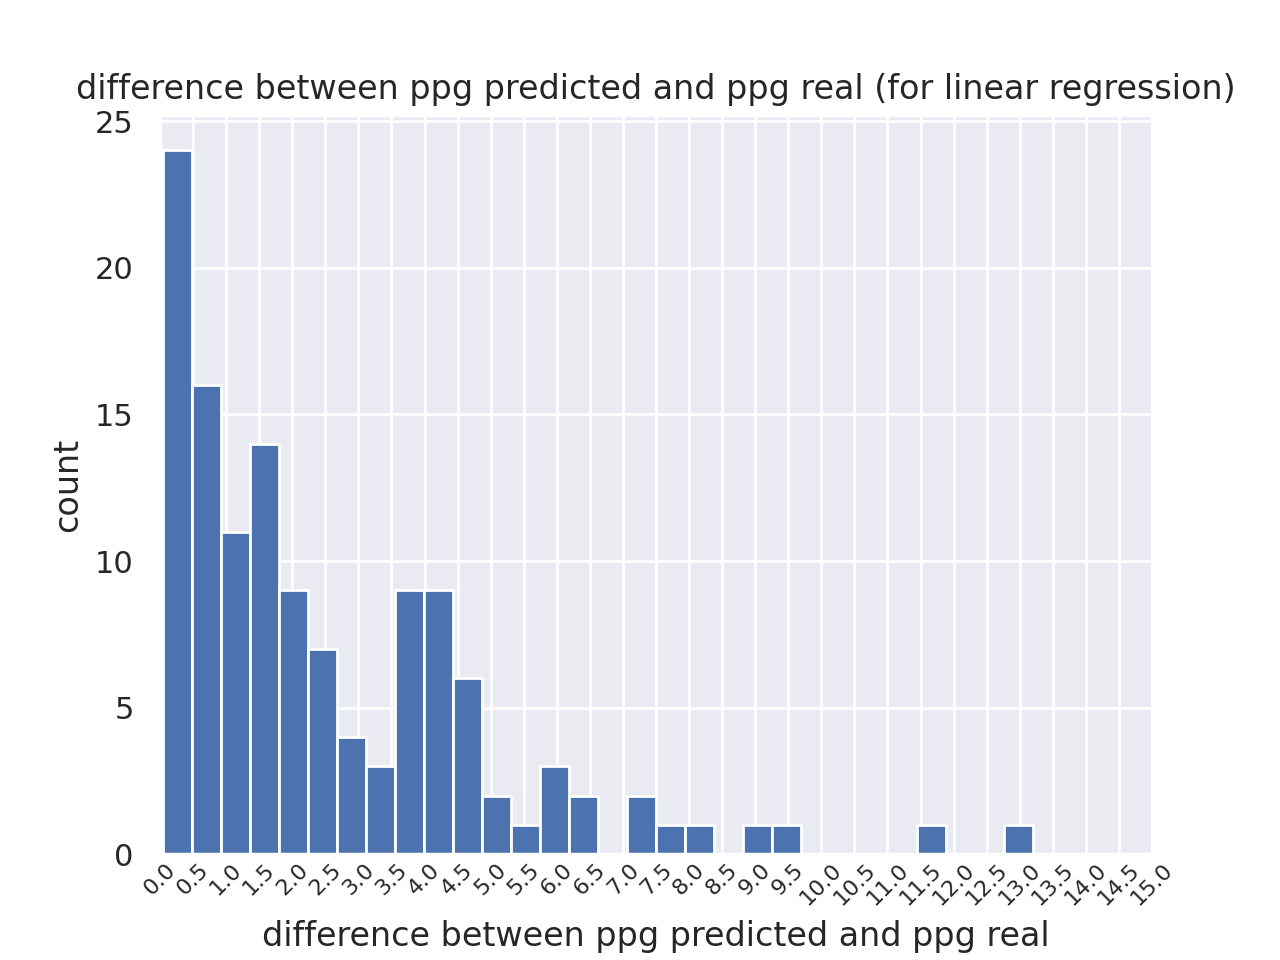

In [194]:
# linear regression histogram

plt.hist(x = check['diff'], bins = 30)
plt.xlim(0,15)
plt.xticks(np.arange(0, 15.5, 0.5), rotation = 45, size = 8)
plt.tick_params(axis='x', which='major', pad=-4)
plt.xlabel('difference between ppg predicted and ppg real')
plt.ylabel('count')
plt.title('difference between ppg predicted and ppg real (for linear regression)')
plt.show()

Clearly, for linear regression, most difference lies between 0 and 0.5 which is pretty good. THere are some outlines in the 11.5-12 bucket and 12.5-13 bucket.

In [195]:
# ggplot(check, aes(x = 'diff')) + geom_histogram(bins = 100)

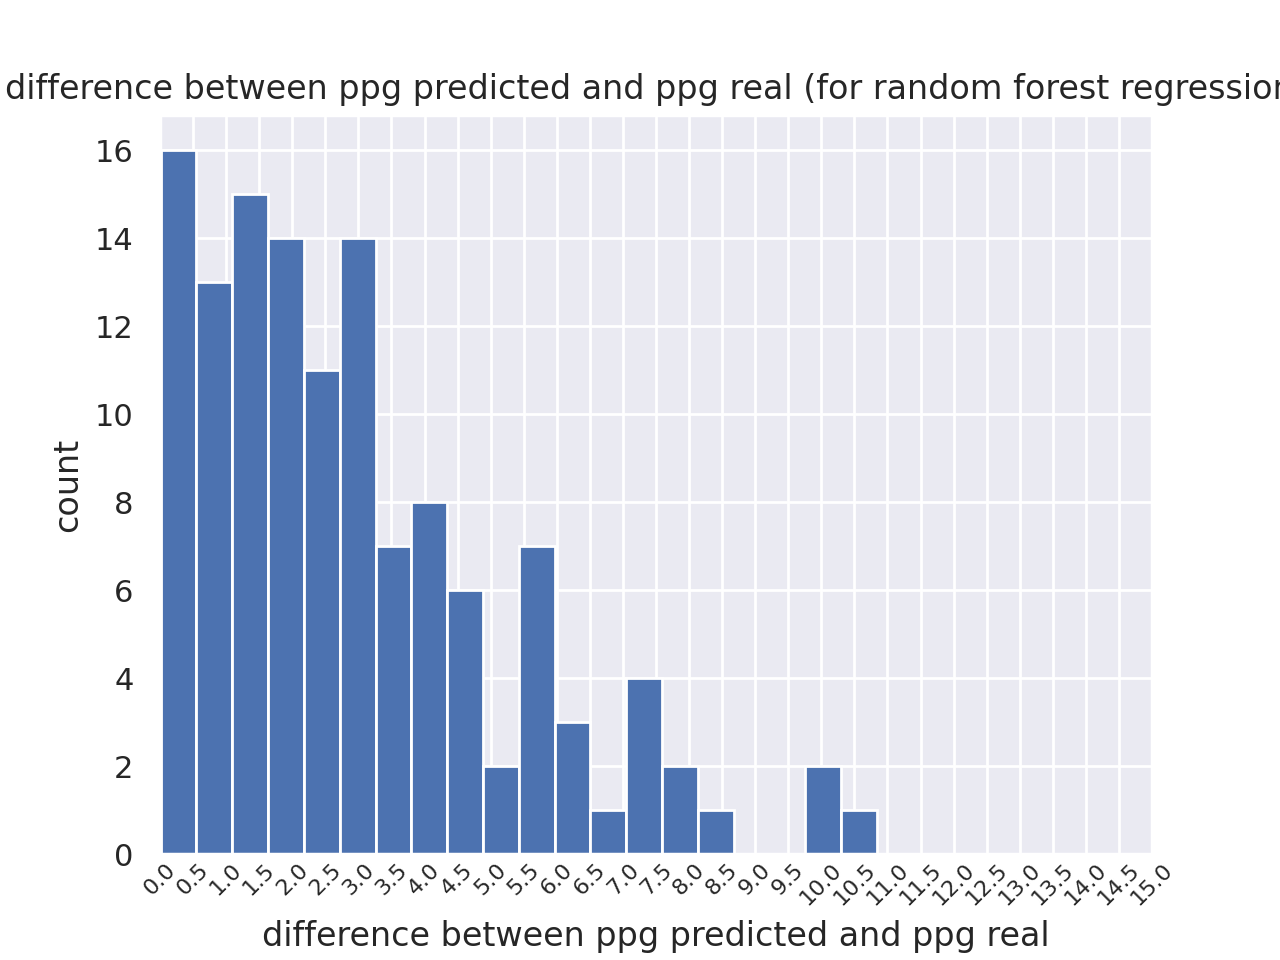

In [196]:
# linear regression histogram

plt.hist(x = b['difference'], bins = 30)
plt.xlim(0,15)
plt.xticks(np.arange(0, 15.5, 0.5), rotation = 45, size = 8)
plt.tick_params(axis='x', which='major', pad=-4)
plt.xlabel('difference between ppg predicted and ppg real')
plt.ylabel('count')
plt.title('difference between ppg predicted and ppg real (for random forest regression)')
plt.show()

This distribution is a bit more evenly distributed. **Linear regression average difference = 2.56,** **random forest regression average difference = 3.07. Linear Regression performs better**.

### predicting rpg (lr better)

In [197]:
# predicitng rpg with linear regression

model_rpg = LinearRegression()

X_rpg = merge.loc[:, ['mpg_x', 'Rookie Of The Month_x', 'allstar_rk_x', 'WS_x', 'efg_x', 'games_start_x', 'ppg_x', 'games_start_x', 'usg_x', 'rpg_x', 'off_rpg_x', 'def_rpg_x', 'bpg_x', 'BPM_x', 'WS_x', 'tot_reb_pct_x', 'def_reb_pct_x', 'off_reb_pct_x', 'PER_x']]
y_rpg = merge.loc[:, 'rpg_y']

X_rpg.fillna(0, inplace= True)
y_rpg.fillna(0, inplace = True)

X_train_rpg, X_test_rpg, y_train_rpg, y_test_rpg = train_test_split(X_rpg, y_rpg, train_size = 0.65, random_state = 12)

model_rpg.fit(X_train_rpg, y_train_rpg)

LinearRegression()

In [198]:
# prediction for rpg with linear regression

y_pred_rpg_lr = model_rpg.predict(X_test_rpg)

b = pd.DataFrame({'y_predict_rpg': y_pred_rpg_lr, 'y_real': y_test_rpg})
b['difference'] = abs(b['y_predict_rpg'] - b['y_real'])
print(b['difference'].mean())
b

0.9214999111755429


,y_predict_rpg,y_real,difference
player,,,
J.J. Hickson,7.310299,8.567067,1.256768
Torrey Craig,4.350314,4.047565,0.302749
Tyler Zeller,5.529726,3.525210,2.004516
Sergio Rodriguez,2.005485,2.308824,0.303338
Delonte West,2.997061,2.761332,0.235729
...,...,...,...
Danilo Gallinari,4.727165,5.542596,0.815431
Stephen Curry,4.219433,5.422352,1.202918
Jusuf Nurkic,8.264492,10.138478,1.873986


In [199]:
model_rpg.coef_

#['mpg_x', 'Rookie Of The Month_x', 'allstar_rk_x', 'WS_x', 'efg_x', 'games_start_x',
#'ppg_x', 'games_start_x', 'usg_x', 'rpg_x', 'off_rpg_x', 'def_rpg_x', 'bpg_x',
#'BPM_x', 'WS_x', 'tot_reb_pct_x', 'def_reb_pct_x', 'off_reb_pct_x', 'PER_x']

array([-3.30036324e-02, -3.63876636e-01,  2.42914188e-03,  1.05774374e-01,
        2.55615609e+00,  1.90001511e-03,  1.28760709e-02,  1.90001511e-03,
       -2.77038067e+00,  2.56975637e+01, -2.56635382e+01, -2.48678137e+01,
        4.30216033e-01, -1.87064445e-01,  1.05774374e-01, -2.92780095e+01,
        1.61071224e+01,  3.03563724e+01,  9.06177636e-02])

In [200]:
model_rpg.intercept_

-1.4837997743876716

In [201]:
print(model_rpg.score(X_rpg, y_rpg))

0.7744123255407305


In [202]:
b.nsmallest(5, 'difference')

,y_predict_rpg,y_real,difference
player,,,
Toney Douglas,2.327988,2.344262,0.016275
Andre Roberson,4.764324,4.743590,0.020734
Ronnie Price,1.501221,1.478253,0.022968
Harrison Barnes,5.121866,5.096585,0.025282
Ryan Anderson,5.773603,5.747824,0.025779


In [203]:
# predicting rpg with random forest regression

X_train_rpg, X_test_rpg, y_train_rpg, y_test_rpg = train_test_split(X_rpg, y_rpg, train_size = 0.65, random_state = 10)

tree = RandomForestRegressor(n_estimators = 100, random_state = 0)

tree.fit(X_train_rpg, y_train_rpg)

y_pred_rpg_rfr = tree.predict(X_test_rpg)

b = pd.DataFrame({'y_predict_rpg': y_pred_rpg_rfr, 'y_real': y_test_rpg})
b['difference'] = abs(b['y_predict_rpg'] - b['y_real'])
print(b['difference'].mean())

# linear regression performs slightly better

1.0925645902503764


In [204]:
y_pred_rpg_lr = model_lr.fit(X_rpg, y_rpg)
y_pred_rpg_lr = model_lr.predict(X_rpg)

Linear regression performs better

### predicting WS (lr better)

In [205]:
# predicint win share with random forest

X_ws = merge.loc[:,['mpg_x', 'Rookie Of The Month_x', 'allstar_rk_x', 'WS_x', 'efg_x', 'mins_x', 'games_start_x', 'ppg_x', 'games_start_x', 'usg_x', 'rpg_x', 'off_rpg_x', 'def_rpg_x', 'bpg_x', 'BPM_x', 'WS_x', 'tot_reb_pct_x', 'def_reb_pct_x', 'off_reb_pct_x', 'PER_x']]
y_ws = merge.loc[:,'WS_y']

X_ws.fillna(0, inplace = True)
y_ws.fillna(0, inplace = True)

X_train_ws, X_test_ws, y_train_ws, y_test_ws = train_test_split(X_ws, y_ws, train_size = 0.65, random_state = 12)

model_lr = LinearRegression()

print(X_test_ws.shape, y_test_ws.shape)

(128, 20) (128,)


In [206]:
model_lr.fit(X_train_ws, y_train_ws)

y_pred_ws_lr = model_lr.predict(X_test_ws)

b = pd.DataFrame({'y_predict_rpg': y_pred_ws_lr, 'y_real': y_test_ws})
b['difference'] = abs(b['y_predict_rpg'] - b['y_real'])
print(b['difference'].mean())

1.3771098779973798


In [207]:
model_lr.coef_

array([ 8.68509012e-02, -2.88071919e-01, -2.48232490e-03,  4.63854480e-01,
        3.83672544e-01, -1.98802050e-03,  4.31518112e-03,  9.44780455e-02,
        4.31518112e-03, -8.79301271e+00,  2.44487075e+01, -2.56456370e+01,
       -2.42082475e+01,  2.34064653e-01, -1.14463119e-01,  4.63854480e-01,
       -2.65516052e+01,  1.27782778e+01,  2.58188656e+01,  1.13310795e-01])

In [208]:
model_lr.intercept_

0.45860370054664523

In [209]:
model_rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)

model_rfr.fit(X_train_ws, y_train_ws)

y_pred_ws_rfr = model_rfr.predict(X_test_ws)

b = pd.DataFrame({'y_predict_rpg': y_pred_ws_rfr, 'y_real': y_test_ws})
b['difference'] = abs(b['y_predict_rpg'] - b['y_real'])
print(b['difference'].mean())

1.4321119791666668


In [210]:
b

,y_predict_rpg,y_real,difference
player,,,
J.J. Hickson,3.226667,4.000000,0.773333
Torrey Craig,2.962500,2.000000,0.962500
Tyler Zeller,3.213333,1.250000,1.963333
Sergio Rodriguez,1.837333,0.700000,1.137333
Delonte West,4.556667,3.966667,0.590000
...,...,...,...
Danilo Gallinari,6.109000,6.933333,0.824333
Stephen Curry,7.304167,12.200000,4.895833
Jusuf Nurkic,4.017333,4.600000,0.582667


In [211]:
print(b['difference'].mean())

# linear regression once again performs better

1.4321119791666668


In [212]:
merge.loc[:,'WS_x'].describe()

count    363.000000
mean       3.272342
std        2.501891
min       -0.400000
25%        1.590000
50%        2.760000
75%        4.380000
max       15.200000
Name: WS_x, dtype: float64

In [213]:
y_pred_ws_lr = model_lr.fit(X_ws, y_ws)
y_pred_ws_lr = model_lr.predict(X_ws)

Linear regression performs better

### predicting OBPM (rfr better)

In [214]:
X_obpm = merge.loc[:,['OBPM_x', 'mpg_x', 'Rookie Of The Month_x', 'allstar_rk_x', 'WS_x', 'efg_x', 'mins_x', 'games_start_x', 'ppg_x', 'games_start_x', 'usg_x', 'rpg_x', 'off_rpg_x', 'BPM_x', 'WS_x', 'tot_reb_pct_x', 'off_reb_pct_x', 'PER_x']]
y_obpm = merge.loc[:,'OBPM_y']

X_obpm.fillna(0, inplace= True)
y_obpm.fillna(0, inplace = True)

X_train_obpm, X_test_obpm, y_train_obpm, y_test_obpm = train_test_split(X_obpm, y_obpm, train_size = 0.65, random_state = 12)

model_lr = LinearRegression()

print(X_train_obpm.shape, y_train_obpm.shape)

(235, 18) (235,)


In [215]:
model_lr.fit(X_train_obpm, y_train_obpm)

y_pred_obpm_lr = model_lr.predict(X_test_obpm)

b = pd.DataFrame({'y_predict_rpg': y_pred_obpm_lr, 'y_real': y_test_obpm})
b['difference'] = abs(abs(b['y_predict_rpg']) - abs(b['y_real']))
print(b['difference'].mean())
b

1.0791499070125052


,y_predict_rpg,y_real,difference
player,,,
J.J. Hickson,-0.439491,-0.233333,0.206158
Torrey Craig,-0.863542,-1.133333,0.269792
Tyler Zeller,-0.616008,-1.450000,0.833992
Sergio Rodriguez,-0.312573,-1.200000,0.887427
Delonte West,0.349683,-0.266667,0.083016
...,...,...,...
Danilo Gallinari,2.293775,4.133333,1.839558
Stephen Curry,4.457902,8.500000,4.042098
Jusuf Nurkic,-0.184837,0.833333,0.648496


In [216]:
X_obpm.fillna(0, inplace= True)
y_obpm.fillna(0, inplace = True)

model_rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)
model_rfr.fit(X_obpm, y_obpm)
y_pred_obpm_rfr = model_rfr.predict(X_obpm)

b = pd.DataFrame({'y_predict_rpg': y_pred_obpm_rfr, 'y_real': y_obpm})
b['difference'] = abs(abs(b['y_predict_rpg']) - abs(b['y_real']))
print(b['difference'].mean())
b

# here, random forest performs better

0.42370707070707064


,y_predict_rpg,y_real,difference
player,,,
Aaron Brooks,-0.230167,-0.566667,0.336500
Aaron Gordon,0.153667,0.233333,0.079667
Al Horford,2.000333,2.033333,0.033000
Al Jefferson,3.178667,2.966667,0.212000
Al-Farouq Aminu,-0.469000,-0.266667,0.202333
...,...,...,...
Will Conroy,-0.227333,0.000000,0.227333
Willie Green,-0.844000,-1.233333,0.389333
Wilson Chandler,-0.063833,0.200000,0.136167


In [217]:
y_pred_obpm_rfr = model_lr.fit(X_obpm, y_obpm)
y_pred_obpm_rfr = model_lr.predict(X_obpm)

Random forest performs better

### predicting PER (rfr better)

In [218]:
X_per = merge.loc[:,['PER_x', 'spg_x', 'bpg_x', 'apg_x', 'OBPM_x', 'mpg_x', 'Rookie Of The Month_x', 'allstar_rk_x', 'WS_x', 'efg_x', 'mins_x', 'games_start_x', 'ppg_x', 'games_start_x', 'usg_x', 'rpg_x', 'off_rpg_x', 'BPM_x', 'WS_x', 'tot_reb_pct_x', 'off_reb_pct_x']]
y_per = merge.loc[:,'PER_y']

X_per.fillna(0, inplace= True)
y_per.fillna(0, inplace = True)

X_train_per, X_test_per, y_train_per, y_test_per = train_test_split(X_per, y_per, train_size = 0.65, random_state = 12)

model_lr = LinearRegression()

print(X_train_per.shape, y_train_per.shape)

(235, 21) (235,)


In [219]:
model_lr.fit(X_train_per, y_train_per)

y_pred_per_lr = model_lr.predict(X_test_per)

b = pd.DataFrame({'y_predict_rpg': y_pred_per_lr, 'y_real': y_test_per})
b['difference'] = abs(abs(b['y_predict_rpg']) - abs(b['y_real']))
print(b['difference'].mean())
b

2.380115171139713


,y_predict_rpg,y_real,difference
player,,,
J.J. Hickson,15.099112,16.733333,1.634221
Torrey Craig,12.758729,12.233333,0.525395
Tyler Zeller,15.149079,14.150000,0.999079
Sergio Rodriguez,10.260883,11.100000,0.839117
Delonte West,14.656241,14.400000,0.256241
...,...,...,...
Danilo Gallinari,17.043777,19.833333,2.789556
Stephen Curry,22.888471,27.400000,4.511529
Jusuf Nurkic,18.391247,21.300000,2.908753


In [220]:
print(model_lr.coef_, model_lr.intercept_)

[ 5.95315940e-01  8.93863461e-01  9.72844566e-01  3.06178168e-01
 -4.47921587e-01  3.23574723e-02  3.05376721e-02  9.11912877e-03
  2.74472759e-01  5.75346462e+00 -9.69420208e-04 -1.35786444e-02
  6.88336741e-01 -1.35786444e-02 -3.03522125e+01  1.21569801e-01
 -2.44239438e+00 -2.56537318e-01  2.74472759e-01  1.04240342e+01
  3.71120331e+01] -0.804388186627456


In [221]:
merge.loc[:, 'PER_x'].describe()

count    363.000000
mean      14.335069
std        4.427447
min       -6.500000
25%       11.810000
50%       14.030000
75%       16.650000
max       32.900000
Name: PER_x, dtype: float64

In [222]:
model_rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)

model_rfr.fit(X_train_per, y_train_per)

y_pred_per_rfr = model_rfr.predict(X_test_per)

b = pd.DataFrame({'y_predict_rpg': y_pred_per_rfr, 'y_real': y_test_per})
b['difference'] = abs(abs(b['y_predict_rpg']) - abs(b['y_real']))
print(b['difference'].mean())
b

# random forest performs slightly better

2.21298046875


,y_predict_rpg,y_real,difference
player,,,
J.J. Hickson,16.135000,16.733333,0.598333
Torrey Craig,11.216667,12.233333,1.016667
Tyler Zeller,15.675000,14.150000,1.525000
Sergio Rodriguez,12.538333,11.100000,1.438333
Delonte West,13.516500,14.400000,0.883500
...,...,...,...
Danilo Gallinari,17.879833,19.833333,1.953500
Stephen Curry,23.225333,27.400000,4.174667
Jusuf Nurkic,18.493000,21.300000,2.807000


In [223]:
y_pred_per_rfr = model_lr.fit(X_per, y_per)
y_pred_per_rfr = model_lr.predict(X_per)

Random forest perofrms better

### predicting efg (rfr better)

In [224]:
X_efg = merge.loc[:,['PER_x', 'OBPM_x', 'mpg_x', 'Rookie Of The Month_x', 'allstar_rk_x', 'WS_x', 'efg_x', 'fgp_x', 'mins_x', 'games_start_x', 'ppg_x', 'games_start_x', 'usg_x', 'rpg_x', 'off_rpg_x', 'BPM_x', 'WS_x', 'tot_reb_pct_x', 'off_reb_pct_x']]
y_efg = merge.loc[:,'efg_y']

X_efg.fillna(0, inplace= True)
y_efg.fillna(0, inplace = True)

X_train_efg, X_test_efg, y_train_efg, y_test_efg = train_test_split(X_efg, y_efg, train_size = 0.65, random_state = 12)

model_lr = LinearRegression()

print(X_train_efg.shape, y_train_efg.shape)

(235, 19) (235,)


In [225]:
model_lr.fit(X_train_efg, y_train_efg)

y_pred_efg_lr = model_lr.predict(X_test_efg)

b = pd.DataFrame({'y_predict_rpg': y_pred_efg_lr, 'y_real': y_test_efg})
b['difference'] = abs(abs(b['y_predict_rpg']) - abs(b['y_real']))
print(b['difference'].mean())
b

0.054371065191176196


,y_predict_rpg,y_real,difference
player,,,
J.J. Hickson,0.479309,0.515000,0.035691
Torrey Craig,0.565114,0.550333,0.014781
Tyler Zeller,0.544468,0.531000,0.013468
Sergio Rodriguez,0.401901,0.478000,0.076099
Delonte West,0.518774,0.501000,0.017774
...,...,...,...
Danilo Gallinari,0.536822,0.524333,0.012489
Stephen Curry,0.558614,0.613000,0.054386
Jusuf Nurkic,0.490963,0.530000,0.039037


In [226]:
model_lr.coef_, model_lr.intercept_

(array([ 3.47903228e-03, -9.50300057e-03,  5.27332045e-03, -6.53140725e-03,
         6.34523001e-04, -1.30258124e-03,  5.27413025e-01,  2.03644550e-01,
         3.85691809e-05, -6.29845246e-04,  3.94623688e-03, -6.29845246e-04,
        -7.43320354e-01,  5.78978215e-03, -6.34874204e-02,  4.18938001e-03,
        -1.30258124e-03,  1.86147002e-01,  7.45534405e-01]),
 0.0449406368182404)

In [227]:
model_lr.score(X_train_efg, y_train_efg)

0.4751825754695431

In [228]:
model_rfr = RandomForestRegressor(n_estimators = 100, random_state = 12)

model_rfr.fit(X_train_efg, y_train_efg)

y_pred_efg_rfr = model_rfr.predict(X_test_efg)

b = pd.DataFrame({'y_predict_rpg': y_pred_efg_rfr, 'y_real': y_test_efg})
b['difference'] = abs(abs(b['y_predict_rpg']) - abs(b['y_real']))
print(b['difference'].mean())
b

# random forest outperforms very slightly

0.04339949218750001


,y_predict_rpg,y_real,difference
player,,,
J.J. Hickson,0.517950,0.515000,0.002950
Torrey Craig,0.562047,0.550333,0.011713
Tyler Zeller,0.534578,0.531000,0.003578
Sergio Rodriguez,0.511933,0.478000,0.033933
Delonte West,0.525995,0.501000,0.024995
...,...,...,...
Danilo Gallinari,0.532977,0.524333,0.008643
Stephen Curry,0.562368,0.613000,0.050632
Jusuf Nurkic,0.498842,0.530000,0.031158


In [229]:
y_pred_efg_rfr = model_lr.fit(X_efg, y_efg)
y_pred_efg_rfr = model_lr.predict(X_efg)

random forest performs better

### merge new data frame and start classification

In [230]:
# y_pred_ppg_lr, y_pred_rpg_lr, y_pred_ws_lr, y_pred_obpm_rfr, y_pred_per_rfr, y_pred_efg_rfr

In [231]:
# Assuming y_test_ppg is a Series, convert it to a DataFrame
y_test_ppg_df = y_ppg.reset_index()
y_test_ppg_df.columns = ['Player', 'PPG']  # Rename columns appropriately

# Convert numpy arrays to pandas Series, making sure to match the index of y_test_ppg_df
y_pred_ppg_lr_series = pd.Series(y_pred_ppg_lr, index=y_test_ppg_df.index, name='pred_ppg')
y_pred_rpg_lr_series = pd.Series(y_pred_rpg_lr, index=y_test_ppg_df.index, name='pred_rpg')
y_pred_ws_lr_series = pd.Series(y_pred_ws_lr, index=y_test_ppg_df.index, name='pred_ws')
y_pred_obpm_rfr_series = pd.Series(y_pred_obpm_rfr, index=y_test_ppg_df.index, name='pred_obpm')
y_pred_per_rfr_series = pd.Series(y_pred_per_rfr, index=y_test_ppg_df.index, name='pred_per')
y_pred_efg_rfr_series = pd.Series(y_pred_efg_rfr, index=y_test_ppg_df.index, name='pred_efg')

# Merge these Series into the DataFrame
final_df = pd.concat([y_test_ppg_df, y_pred_ppg_lr_series, y_pred_rpg_lr_series, y_pred_ws_lr_series, y_pred_obpm_rfr_series, y_pred_per_rfr_series, y_pred_efg_rfr_series], axis=1)

final_df.head(50)  # Print the first few rows to check the result


,Player,PPG,pred_ppg,pred_rpg,pred_ws,pred_obpm,pred_per,pred_efg
0,Aaron Brooks,8.902203,13.087884,1.806057,3.048134,0.874728,12.707246,0.436673
1,Aaron Gordon,15.135682,13.654975,6.578287,4.450061,0.432688,15.971155,0.523085
2,Al Horford,15.953718,13.866176,9.337900,6.970382,1.594828,19.375865,0.567631
3,Al Jefferson,21.378648,25.351170,10.770642,7.170911,3.241217,23.479793,0.500927
4,Al-Farouq Aminu,9.649252,7.576572,5.708621,2.618028,-1.511219,12.524848,0.488483
5,Alec Burks,14.036258,12.326466,3.162870,2.864985,0.567399,13.626544,0.451828
6,Alex Len,9.441052,9.392260,7.525856,3.323863,-1.196292,15.764072,0.550363
7,Alexis Ajinca,6.112650,5.003316,3.232268,1.958447,-1.524354,9.967287,0.388408
8,Alonzo Gee,4.431027,6.677822,3.113630,2.107693,-1.372767,10.144227,0.460688
9,Amir Johnson,9.989739,8.001733,6.077256,4.660885,-1.195240,17.809747,0.616577


In [232]:
def stat_mean(df, stat_name, quantile):
    """
    This stat_mean() function takes a df, a stat name, and returns the top quantile of the mean of that stat

    df - dataframe that you want to operate on
    stat_name - the stat (ppg, win shares, rebounds, steals, etc) that you want to find top x% of
    quantile - the top percent that you want to find
    """
    df_describe = df[df['games'] >= 50]
    df_describe = df_describe.groupby('player')[stat_name].mean()
    quantile = df_describe.quantile(quantile)
    return quantile

def stat_sum(df, stat_name, quantile):
    """
    This stat_sum() function takes a df, a stat name, and returns the top quantile of the sum of that stat. This
    would be more useful that stat_mean() if you want the criteria to be per season and not per game (a player must play 5000
    minutes over the course of their career vs. a player must play 20 minutes a game etc.)

    df - dataframe that you want to operate on
    stat_name - the stat (ppg, win shares, rebounds, steals, etc) that you want to find top x% of
    quantile - the top percent that you want to find
    """
    df_describe = df[df['games'] >= 50]
    df_describe = df_describe.groupby('player')[stat_name].sum()
    quantile = df_describe.quantile(quantile)
    return quantile

In [233]:
# all nba bucket
"""
The all NBA bucket should have the criteria below OR have a previous all nba appearance
"""

# ppg
stat_name, quantile = 'ppg', 0.90
print("the top 10% score more than", stat_mean(player_data_top3, stat_name, quantile), " ppg")

# win shares
stat_name, quantile = 'WS', 0.90
print("the top 10% have more than ", stat_mean(player_data_top3, stat_name, quantile), " ws")

# offensive box plus minus
stat_name, quantile = 'OBPM', 0.80
print("the top 20% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

# PER
stat_name, quantile = 'PER', 0.80
print("the top 20% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

player_data_top3['All NBA'] = (((player_data_top3.loc[:,['All NBA First Team', 'All NBA Second Team', 'All NBA Third Team']] == 1).any(axis=1)) | ((player_data_top3['ppg'] >=21.359) & (player_data_top3['WS'] >= 8.033) & (player_data_top3['OBPM'] >= 2.0735) & (player_data_top3['PER'] >= 19.052)))

p = player_data_top3[player_data_top3['All NBA'] == True]
p = p.groupby(['player', 'All NBA'])
len(p)


the top 10% score more than 20.404372676302764  ppg
the top 10% have more than  7.740000000000002  ws
the top 20% have more than  1.75  OBPM
the top 20% have more than  18.466666666666665  OBPM


35

In [234]:
# all star bucket
"""
The all NBA bucket should have the criteria below OR have a previous all nba appearance
"""

# ppg
stat_name, quantile = 'ppg', 0.75
print("the top 10% score more than", stat_mean(player_data_top3, stat_name, quantile), " ppg")

# win shares
stat_name, quantile = 'WS', 0.75
print("the top 10% have more than ", stat_mean(player_data_top3, stat_name, quantile), " ws")

# offensive box plus minus
stat_name, quantile = 'OBPM', 0.65
print("the top 20% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

# PER
stat_name, quantile = 'PER', 0.65
print("the top 20% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

player_data_top3['All Star'] = (((player_data_top3['all_star_game'] >= 0.3) | ((player_data_top3['ppg'] >=16.66) & (player_data_top3['WS'] >= 5.5) & (player_data_top3['OBPM'] >= 1.0) & (player_data_top3['PER'] >= 16.8))) & (player_data_top3['All NBA'] == False))

d = player_data_top3[player_data_top3['All Star'] == True]
p = d.groupby(['player', 'All Star'])
len(p)

the top 10% score more than 15.706602438007506  ppg
the top 10% have more than  5.425000000000001  ws
the top 20% have more than  0.7616666666666674  OBPM
the top 20% have more than  16.2  OBPM


76

In [235]:
# starter bucket

# ppg
stat_name, quantile = 'ppg', 0.5
print("the top 50% score more than", stat_mean(player_data_top3, stat_name, quantile), " ppg")

# win shares
stat_name, quantile = 'WS', 0.5
print("the top 50% have more than ", stat_mean(player_data_top3, stat_name, quantile), " ws")

# offensive box plus minus
stat_name, quantile = 'OBPM', 0.4
print("the top 60% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

# PER
stat_name, quantile = 'PER', 0.4
print("the top 60% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

player_data_top3['Starter'] = (((player_data_top3['ppg'] >= 11.4) & (player_data_top3['WS'] >= 3.9) & (player_data_top3['OBPM'] >= -0.4) & (player_data_top3['PER'] >= 14.0)) & ((player_data_top3['All NBA'] == False) & (player_data_top3['All Star'] == False)))

d = player_data_top3[player_data_top3['Starter'] == True]
p = d.groupby(['player', 'Starter'])
len(p)

the top 50% score more than 10.513931160664217  ppg
the top 50% have more than  3.6  ws
the top 60% have more than  -0.6  OBPM
the top 60% have more than  13.543333333333335  OBPM


78

In [236]:
# bench bucket

# ppg
stat_name, quantile = 'ppg', 0.25
print("the top 75% score more than", stat_mean(player_data_top3, stat_name, quantile), " ppg")

# win shares
stat_name, quantile = 'WS', 0.25
print("the top 75% have more than ", stat_mean(player_data_top3, stat_name, quantile), " ws")

# offensive box plus minus
stat_name, quantile = 'OBPM', 0.2
print("the top 80% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

# PER
stat_name, quantile = 'PER', 0.2
print("the top 80% have more than ", stat_mean(player_data_top3, stat_name, quantile), " OBPM")

player_data_top3['Bench'] = ((((player_data_top3['ppg'] >= 7.7) & (player_data_top3['WS'] >= 2.4) & (player_data_top3['OBPM'] >= 2.39) & (player_data_top3['PER'] >= -1.5)) & ((player_data_top3['All NBA'] == False) & (player_data_top3['All Star'] == False) & (player_data_top3['Starter'] == False))) | ((player_data_top3['mins'] >= 1000) & ((player_data_top3['All NBA'] == False) & (player_data_top3['All Star'] == False) & (player_data_top3['Starter'] == False))))

d = player_data_top3[player_data_top3['Bench'] == True]
p = d.groupby(['player', 'Bench'])
len(p)
# d

the top 75% score more than 7.167982619600138  ppg
the top 75% have more than  2.1  ws
the top 80% have more than  -1.7099999999999995  OBPM
the top 80% have more than  11.466666666666667  OBPM


353

In [237]:
# Out of the league bucket

player_data_top3['Out of the league'] = (((player_data_top3['All NBA'] == False) & (player_data_top3['All Star'] == False) & (player_data_top3['Starter'] == False) & (player_data_top3['Bench'] == False)))

d = player_data_top3[player_data_top3['Out of the league'] == True]
p = d.groupby(['player', 'Out of the league'])
len(p)
# d

player_data_top3


,nbapersonid,draftyear,draftpick,season,nbateamid,games,games_start,mins,fgm,fga,fgp,fgm3,fga3,fgp3,fgm2,fga2,fgp2,efg,ftm,fta,ftp,off_reb,def_reb,tot_reb,ast,steals,blocks,tov,tot_fouls,points,PER,FTr,off_reb_pct,def_reb_pct,tot_reb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg,OWS,DWS,WS,OBPM,DBPM,BPM,VORP,ppg,rpg,spg,apg,bpg,off_rpg,def_rpg,All NBA Defensive First Team,All NBA Defensive Second Team,All NBA First Team,All NBA Second Team,All NBA Third Team,All Rookie First Team,All Rookie Second Team,Bill Russell NBA Finals MVP,Player Of The Month,Player Of The Week,Rookie Of The Month,all_star_game,allstar_rk,Defensive Player Of The Year_rk,Most Improved Player_rk,Most Valuable Player_rk,Rookie Of The Year_rk,Sixth Man Of The Year_rk,all_nba_points_rk,all_rookie_points_rk,diff_first_curr,All NBA,All Star,Starter,Bench,Out of the league,Career Outcome
player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron Brooks,201166.0,2007.0,26.0,2013.666667,1.610613e+09,65.666667,13.666667,1317.333333,223.666667,529.666667,0.427000,78.333333,208.333333,0.374000,145.333333,321.333333,0.463000,0.501333,78.000000,96.666667,0.789333,21.666667,93.333333,115.000000,183.000000,37.666667,10.666667,100.666667,136.666667,603.666667,12.766667,0.173667,0.017667,0.077000,0.047667,0.226667,0.014667,0.006333,0.151000,0.219667,0.933333,0.733333,1.700000,-0.566667,-1.266667,-1.833333,0.100000,8.902203,1.727937,0.574585,2.713150,0.160009,0.318487,1.409450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,6.666667,False,False,False,True,False,Bench
Aaron Gordon,203932.0,2014.0,4.0,2019.333333,1.610613e+09,71.666667,71.666667,2342.000000,413.000000,882.333333,0.468667,93.666667,281.333333,0.330667,319.333333,601.000000,0.532667,0.521333,169.000000,235.666667,0.716000,120.333333,375.666667,496.000000,235.000000,50.666667,46.333333,131.666667,148.333333,1088.666667,15.166667,0.270000,0.056000,0.176667,0.115667,0.152000,0.010667,0.017333,0.117333,0.207333,2.133333,2.533333,4.666667,0.233333,-0.233333,0.000000,1.200000,15.135682,6.957866,0.713339,3.296405,0.644549,1.682106,5.275760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.333333,False,False,True,False,False,Starter
Aaron Gray,201189.0,2007.0,49.0,2012.000000,1.610613e+09,41.333333,20.666667,553.666667,52.000000,103.000000,0.493333,0.000000,0.333333,0.000000,52.000000,102.666667,0.496000,0.493333,19.333333,36.333333,0.537000,56.666667,115.666667,172.333333,26.333333,13.000000,10.000000,38.000000,89.666667,123.333333,9.333333,0.363667,0.120000,0.233667,0.177000,0.078667,0.012333,0.014667,0.252667,0.129333,0.033333,0.700000,0.666667,-4.033333,-0.066667,-4.100000,-0.266667,2.849825,4.007524,0.306226,0.637497,0.236137,1.339518,2.668007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,False,False,False,False,True,Out of the league
Aaron Williams,1425.0,1993.0,NaN,2007.000000,1.610613e+09,30.000000,5.000000,297.000000,27.000000,55.000000,0.491000,0.000000,0.000000,NaN,27.000000,55.000000,0.491000,0.491000,14.000000,18.000000,0.778000,15.000000,46.000000,61.000000,9.000000,12.000000,15.000000,13.000000,44.000000,68.000000,10.300000,0.327000,0.058000,0.180000,0.119000,0.049000,0.021000,0.038000,0.171000,0.118000,0.000000,0.400000,0.400000,-4.500000,2.000000,-2.500000,0.000000,2.266667,2.033333,0.400000,0.300000,0.500000,0.500000,1.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.000000,False,False,False,False,True,Out of the league
Adonal Foyle,1502.0,1997.0,8.0,2007.000000,1.610613e+09,82.000000,0.000000,774.000000,70.000000,153.000000,0.458000,0.000000,0.000000,NaN,70.000000,153.000000,0.458000,0.458000,16.000000,34.000000,0.471000,71.000000,137.000000,208.000000,18.000000,16.000000,45.000000,32.000000,94.000000,156.000000,9.900000,0.222000,0.110000,0.196000,0.155000,0.034000,0.011000,0.042000,0.160000,0.11800

In [238]:
#player_data_top3['Career Outcome'] = player_data_top3.loc[:,'All NBA':'Career'].idxmax(axis=1)
#player_data_top3.head(3)


In [239]:
player_data_top3 = player_data_top3[['ppg', 'WS', 'PER', 'OBPM', 'efg', 'All NBA', 'All Star', 'Starter', 'Bench', 'Out of the league', 'Career Outcome']]

In [240]:
player_data_top3

,ppg,WS,PER,OBPM,efg,All NBA,All Star,Starter,Bench,Out of the league,Career Outcome
player,,,,,,,,,,,
Aaron Brooks,8.902203,1.700000,12.766667,-0.566667,0.501333,False,False,False,True,False,Bench
Aaron Gordon,15.135682,4.666667,15.166667,0.233333,0.521333,False,False,True,False,False,Starter
Aaron Gray,2.849825,0.666667,9.333333,-4.033333,0.493333,False,False,False,False,True,Out of the league
Aaron Williams,2.266667,0.400000,10.300000,-4.500000,0.491000,False,False,False,False,True,Out of the league
Adonal Foyle,1.902439,1.300000,9.900000,-3.100000,0.458000,False,False,False,False,True,Out of the league
...,...,...,...,...,...,...,...,...,...,...,...
Yao Ming,20.822078,9.450000,22.600000,1.700000,0.528000,False,True,False,False,False,All Star
Zach LaVine,25.778007,5.233333,20.300000,3.966667,0.558667,False,True,False,False,False,All Star
Zach Randolph,20.567952,7.466667,21.133333,2.766667,0.502000,True,False,False,False,False,All NBA


### gausssianNB classification


In [241]:
# make the features matrix and target vector

X_train = player_data_top3.loc[:,'ppg':'efg']
y_train = player_data_top3.loc[:,'Career Outcome']
print(X_train.shape, y_train.shape)

(745, 5) (745,)


In [242]:
# Will use GNB, SVM, and RFC. Lets do GNB first

model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)

#change order of final_df
d = final_df[['Player', 'PPG', 'pred_ws', 'pred_per', 'pred_obpm', 'pred_efg']]
final_df = final_df[['PPG', 'pred_ws', 'pred_per', 'pred_obpm', 'pred_efg']]
final_df.rename(columns = {'PPG':'ppg', 'pred_ws':'WS', 'pred_per':'PER', 'pred_obpm':'OBPM', 'pred_efg':'efg'}, inplace = True)
final_df

# predict with final_df dataframe
final_pred = model_gnb.predict(final_df)

<ipython-input-242-6d46404d8fd8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [243]:
final_pred_series = pd.DataFrame(final_pred)
final_pred_series

,0
0,Bench
1,Starter
2,Starter
3,All Star
4,Bench
...,...
358,Out of the league
359,Bench
360,Bench
361,All Star


In [244]:
final = pd.concat([d, final_pred_series], axis = 1)
final.set_index(final.columns[0], inplace=True)
#final.head(50)

In [245]:
check = pd.merge(final, player_data_top3.loc[:, 'Career Outcome'], left_index = True, right_index = True)
matches = check[0] == check['Career Outcome']
print(matches.sum()) # percentage of correct classiciations
check.head(50)
# gets 230/350 right or 65%
check.to_csv('check.csv')

230


In [246]:
a_gnb = check[0]
b_gnb = check['Career Outcome']

print(classification_report(a_gnb,b_gnb))
print(accuracy_score(a_gnb,b_gnb))

                   precision    recall  f1-score   support

          All NBA       0.54      0.78      0.64        18
         All Star       0.40      0.53      0.46        32
            Bench       0.83      0.76      0.79       209
Out of the league       0.33      0.47      0.38        32
          Starter       0.56      0.42      0.48        59

         accuracy                           0.66       350
        macro avg       0.53      0.59      0.55       350
     weighted avg       0.69      0.66      0.67       350

0.6571428571428571


### SVM classification

In [247]:
model_svc = SVC(kernel = 'linear', C = 0.01) # higher c means the margin is hard, and points cannot lie on it. Fr smaller C, the margin is sfoter, and can grow to encompass some points
# low c means boundary is larger (wider), and high c means boundary is smaller (thinner)
model_svc.fit(X_train, y_train)

SVC(C=0.01, kernel='linear')

In [248]:
final_pred_svc = model_svc.predict(final_df)
final_pred_series_svc = pd.DataFrame(final_pred_svc)

In [249]:
final_svc = pd.concat([d, final_pred_series_svc], axis = 1)
final_svc.set_index(final_svc.loc[:,'Player'], inplace=True)

In [250]:
check_svc = pd.merge(final_svc, player_data_top3.loc[:, 'Career Outcome'], left_index = True, right_index = True)
check_svc

,Player,PPG,pred_ws,pred_per,pred_obpm,pred_efg,0,Career Outcome
Aaron Brooks,Aaron Brooks,8.902203,3.048134,12.707246,0.874728,0.436673,Bench,Bench
Aaron Gordon,Aaron Gordon,15.135682,4.450061,15.971155,0.432688,0.523085,Bench,Starter
Al Horford,Al Horford,15.953718,6.970382,19.375865,1.594828,0.567631,Starter,All Star
Al Jefferson,Al Jefferson,21.378648,7.170911,23.479793,3.241217,0.500927,All Star,All Star
Al-Farouq Aminu,Al-Farouq Aminu,9.649252,2.618028,12.524848,-1.511219,0.488483,Bench,Bench
...,...,...,...,...,...,...,...,...
Will Bynum,Will Bynum,9.471195,2.107662,12.905916,-0.054805,0.429536,Bench,Bench
Willie Green,Willie Green,9.970982,2.685294,11.958754,-0.110292,0.422643,Bench,Bench
Wilson Chandler,Wilson Chandler,14.429271,3.763291,14.669608,0.028906,0.503593,Bench,Bench
Zach LaVine,Zach LaVine,25.778007,3.265808,16.720534,1.098101,0.507674,All Star,All Star


In [251]:
a_svm = check_svc[0]
b_svm = check_svc.loc[:,'Career Outcome']
print(classification_report(a_svm,b_svm))
print(accuracy_score(a_svm,b_svm))

                   precision    recall  f1-score   support

          All NBA       0.54      0.88      0.67        16
         All Star       0.50      0.54      0.52        39
            Bench       0.94      0.77      0.85       235
Out of the league       0.46      0.84      0.59        25
          Starter       0.31      0.40      0.35        35

         accuracy                           0.71       350
        macro avg       0.55      0.68      0.59       350
     weighted avg       0.78      0.71      0.73       350

0.7142857142857143


it seems like SVM is the best model. It beats the preliminary model by 3%.

### random forest classificatition

In [252]:
model_rfc = RandomForestClassifier(n_estimators = 1000, min_samples_split = 10, min_samples_leaf = 4, max_depth = 15, max_features = 'auto', random_state = 12)
model_rfc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


RandomForestClassifier(max_depth=15, max_features='auto', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1000,
                       random_state=12)

In [253]:
final_pred_rfc = model_rfc.predict(final_df)
final_pred_series_rfc = pd.DataFrame(final_pred_rfc)

In [254]:
final_rfc = pd.concat([d, final_pred_series_rfc], axis = 1)
final_rfc.set_index(final_rfc.loc[:,'Player'], inplace=True)

In [255]:
check_rfc = pd.merge(final_rfc, player_data_top3.loc[:, 'Career Outcome'], left_index = True, right_index = True)
check_rfc

,Player,PPG,pred_ws,pred_per,pred_obpm,pred_efg,0,Career Outcome
Aaron Brooks,Aaron Brooks,8.902203,3.048134,12.707246,0.874728,0.436673,Bench,Bench
Aaron Gordon,Aaron Gordon,15.135682,4.450061,15.971155,0.432688,0.523085,Starter,Starter
Al Horford,Al Horford,15.953718,6.970382,19.375865,1.594828,0.567631,Starter,All Star
Al Jefferson,Al Jefferson,21.378648,7.170911,23.479793,3.241217,0.500927,All Star,All Star
Al-Farouq Aminu,Al-Farouq Aminu,9.649252,2.618028,12.524848,-1.511219,0.488483,Bench,Bench
...,...,...,...,...,...,...,...,...
Will Bynum,Will Bynum,9.471195,2.107662,12.905916,-0.054805,0.429536,Bench,Bench
Willie Green,Willie Green,9.970982,2.685294,11.958754,-0.110292,0.422643,Bench,Bench
Wilson Chandler,Wilson Chandler,14.429271,3.763291,14.669608,0.028906,0.503593,Bench,Bench
Zach LaVine,Zach LaVine,25.778007,3.265808,16.720534,1.098101,0.507674,Bench,All Star


In [256]:
a_rfc = check_rfc[0]
b_rfc = check_rfc.loc[:,'Career Outcome']
print(classification_report(a_rfc,b_rfc))
print(accuracy_score(a_rfc,b_rfc))

                   precision    recall  f1-score   support

          All NBA       0.38      0.77      0.51        13
         All Star       0.40      0.50      0.45        34
            Bench       0.93      0.77      0.84       231
Out of the league       0.37      0.85      0.52        20
          Starter       0.53      0.46      0.49        52

         accuracy                           0.70       350
        macro avg       0.52      0.67      0.56       350
     weighted avg       0.77      0.70      0.72       350

0.7028571428571428


### logistic regression

In [257]:
model_logreg = LogisticRegression(max_iter=1000)
model_logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [258]:
final_pred_logreg = model_logreg.predict(final_df)
final_pred_series_logreg = pd.DataFrame(final_pred_logreg)

In [259]:
final_logreg = pd.concat([d, final_pred_series_logreg], axis = 1)
final_logreg.set_index(final_logreg.loc[:,'Player'], inplace=True)

In [260]:
check_logreg = pd.merge(final_logreg, player_data_top3.loc[:, 'Career Outcome'], left_index = True, right_index = True)
check_logreg

,Player,PPG,pred_ws,pred_per,pred_obpm,pred_efg,0,Career Outcome
Aaron Brooks,Aaron Brooks,8.902203,3.048134,12.707246,0.874728,0.436673,Bench,Bench
Aaron Gordon,Aaron Gordon,15.135682,4.450061,15.971155,0.432688,0.523085,Bench,Starter
Al Horford,Al Horford,15.953718,6.970382,19.375865,1.594828,0.567631,All Star,All Star
Al Jefferson,Al Jefferson,21.378648,7.170911,23.479793,3.241217,0.500927,All Star,All Star
Al-Farouq Aminu,Al-Farouq Aminu,9.649252,2.618028,12.524848,-1.511219,0.488483,Bench,Bench
...,...,...,...,...,...,...,...,...
Will Bynum,Will Bynum,9.471195,2.107662,12.905916,-0.054805,0.429536,Bench,Bench
Willie Green,Willie Green,9.970982,2.685294,11.958754,-0.110292,0.422643,Bench,Bench
Wilson Chandler,Wilson Chandler,14.429271,3.763291,14.669608,0.028906,0.503593,Bench,Bench
Zach LaVine,Zach LaVine,25.778007,3.265808,16.720534,1.098101,0.507674,All Star,All Star


In [261]:
a_logreg = check_logreg[0]
b_logreg = check_logreg.loc[:,'Career Outcome']
print(classification_report(a_logreg,b_logreg))
print(accuracy_score(a_logreg,b_logreg))

                   precision    recall  f1-score   support

          All NBA       0.54      0.82      0.65        17
         All Star       0.55      0.53      0.54        43
            Bench       0.92      0.76      0.83       229
Out of the league       0.37      0.77      0.50        22
          Starter       0.36      0.41      0.38        39

         accuracy                           0.70       350
        macro avg       0.55      0.66      0.58       350
     weighted avg       0.76      0.70      0.72       350

0.7


## Finding the best classification model

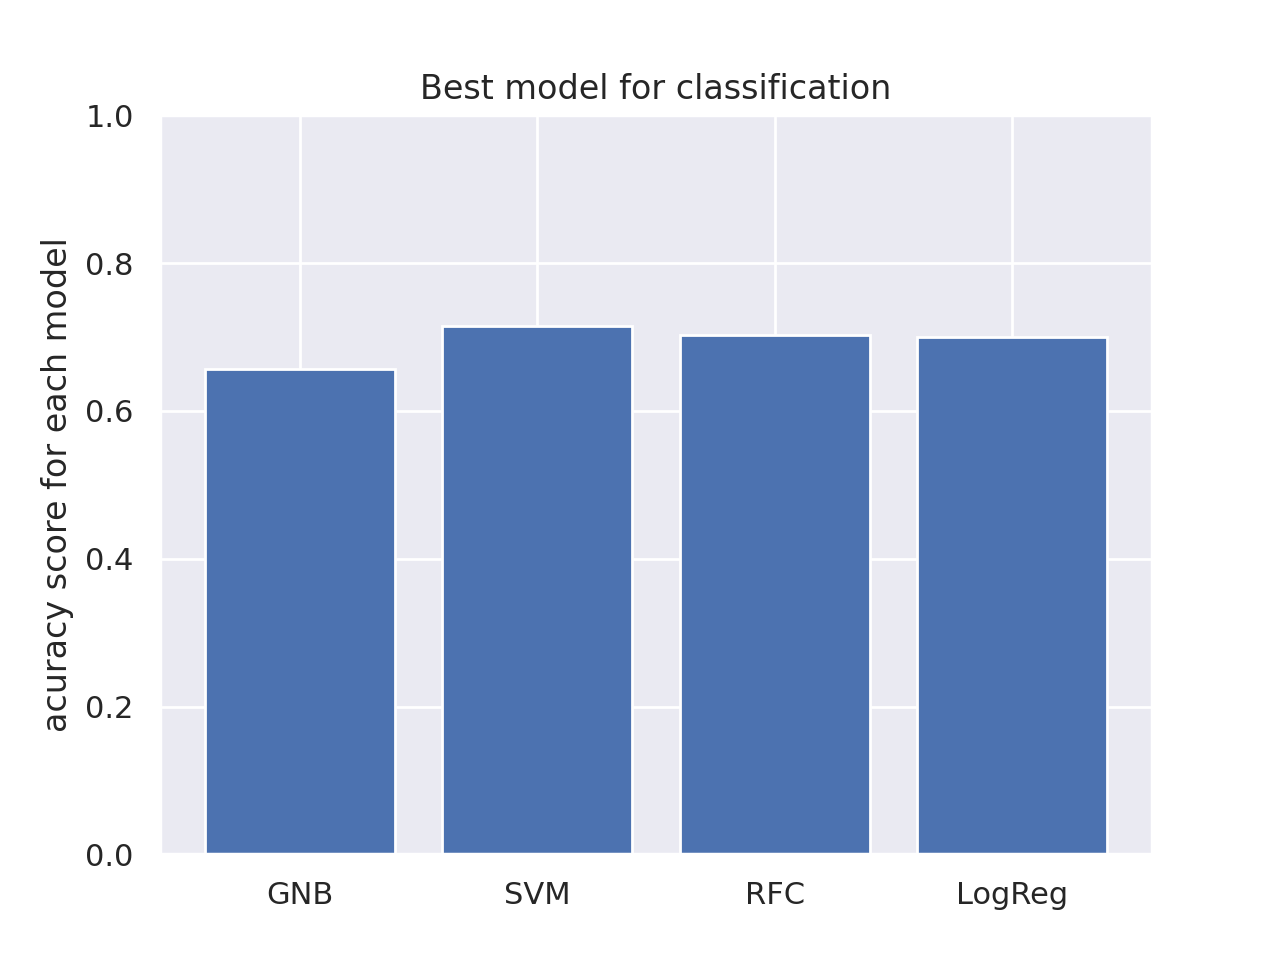

In [266]:
plt.bar(x = ['GNB', 'SVM', 'RFC', 'LogReg'], height = [accuracy_score(a_gnb,b_gnb), accuracy_score(a_svm,b_svm), accuracy_score(a_rfc,b_rfc), accuracy_score(a_logreg,b_logreg)])
plt.ylim(0,1)
plt.ylabel('acuracy score for each model')
plt.title('Best model for classification')
plt.show()

The support vector classifier is the best classifier by accuracy score.

# Tuning hyperparameters For Attempt 2

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# random forest

param_grid = {
    'n_estimators': [100, 200, 500, 1000],  # Number of trees in the forest
    'max_depth': [5, 10, 15],  # Maximum depth of the trees
    'min_samples_split': [10, 15],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [4, 6, 8],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto']  # Number of features to consider when looking for the best split
}

grid_search = GridSearchCV(estimator=model_rfc, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best hyperparameters from the grid search
best_params = grid_search.best_params_

In [ ]:
best_params

# Conclusion

In this project, I attempted to predict career outcome in two different ways:

1.) The first attempt was a lot simpler. I simply used a GaussianNB classifer and averaged the first 4 seasons of young players and made that my test data. I also averaged teh first 4 seasons of more experienced playesr who HAVE a career outcome, and used that as training data. This yielded an **accuracy score of around 0.68**

2.) The second attempt was a bit more advanced. I first predicted the ppg, ws, obpm, per, and efg of players, and then based on these predicted stats, I used 4 different classifiers (logistic regression, random forest classification, support vector classifiation, and gaussian naive bayes classificaion) to classify these players into different career outcomes. Some models performed better than others, but I found that the support vector classifier performed the best with an **accuracy score of 0.714.** Another added advantage of this second attempt is that it predcits stats, so we can look at those as well.

While I think my models both do a pretty good job of predicting career outcome just based on the eye test, there is still a lot of room for improvement.

For example, I think getting some data on some younger players and using the eye test (pesronal judgement) would be good testing data. FOr example, we do not know someone like james wiseman's career outcome yet, however just using our personal judgment we can see whether or not the model's prediction is accurate.

I also think merging this dataset with other datasets that have more advanced stats would slightly improve the accuracy scores of our models. This dataset has pretty standard statistics, which are great, but I think advanced statistics would take this model to the next level

